## 1) Setup

We import:
- **Data / math**: `polars`, `numpy`, `datetime`
- **ML**: `torch`
- **Viz**: `altair`
- **Local project code**: `xrp_model.{research, binance, models}`

> Note: if `ModuleNotFoundError: xrp_model` appears, it means the notebook kernel is not using the project virtual environment where the package was installed (`pip install -e .`). In VS Code, select the `.venv` interpreter and restart the kernel.

In [1]:
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms                          


# Visualization and 
import altair as alt                        # Interactive visualization library
from xrp_model import research, binance, models

## Experiment setup

We define the market and sampling choices used throughout the notebook:

- **Symbol:** `XRPUSDT`
- **Bar interval:** `8h` (each observation is one 8-hour candle)
- **Sample period:** from **2023-02-11** to **2026-02-11**
- **Forecast horizon:** `h = 1` bar ahead  

In [2]:
sym ='XRPUSDT'
forecast_horizon = 1
start_date = datetime(2023, 2, 11, 0, 0)
end_date   = datetime(2026, 2, 11, 0, 0)
time_interval = '8h'

In [3]:
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)

Loading XRPUSDT:   0%|          | 0/1097 [00:00<?, ?day/s]

Loading XRPUSDT: 100%|██████████| 1097/1097 [00:26<00:00, 41.55day/s]


## Environment configuration and feature construction

- `research.set_seed(99)`  
  Fixes the random seed to ensure reproducibility of:
  - model weight initialization
  - any stochastic components in training

This guarantees that model parameters and performance metrics are stable across runs.

---

### Annualization factor


-> annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)

For an 8-hour bar:

- 24 / 8 = 3 bars per day  
- Approximately 3 × 365 = 1095 bars per year  

This factor is later used to annualize the Sharpe ratio:

$$
Sharpe_{annual} = \frac{\mu_{bar}}{\sigma_{bar}} \sqrt{annualized\_rate}
$$

where:

$$
\mu_{bar} = \text{mean log return per bar}
$$

$$
\sigma_{bar} = \text{standard deviation per bar}
$$

---

ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)

With forecast_horizon = 1, the base return is:

$$
r_t = \log\left(\frac{C_t}{C_{t-1}}\right)
$$

This return is stored as:

target = 'close_log_return'

So the model predicts one-bar-ahead close-to-close log returns.

---

feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]

For no_lags = 6, the features are:

$$
{ r_{t-1}, r_{t-2}, \dots, r_{t-6} }
$$

This is a linear autoregressive structure:

$$
\hat{r}t = \beta_1 r_{t-1} + \beta_2 r_{t-2} + \dots + \beta_6 r_{t-6} + b 
$$


In [4]:
pl.Config.set_fmt_str_lengths(200)
research.set_seed(99)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)
no_lags = 6
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]

### Quick feature screening: `research.benchmark_linear_models(...)`

This cell is a **brute-force baseline** to see which subsets of lagged returns are most predictive **before** we invest time into walk-forward / execution details.

#### What goes in
We pass:
- `target = "close_log_return"`
- `feature_pool = ["close_log_return_lag_1", ..., "close_log_return_lag_6"]`
- `annualized_rate`
- `max_no_features=5` → we try feature subsets of size 1..5
- `no_epochs=200`, `loss=MSELoss`, `test_size=0.25`

#### What the function does under the hood (from `research.py`)
1) **Enumerates feature subsets**
- Uses all combinations of `feature_pool` with size $k=1,\dots,\text{max\_no\_features}$.

2) **Time-series split (no shuffle)**
- Uses `timeseries_train_test_split(...)` which splits by index:
  - Train = first $(1-\text{test\_size})$ fraction
  - Test = last $\text{test\_size}$ fraction  
So this is a “past → future” split (good), but **only one split** (not walk-forward).

3) **Trains a linear regression model**
- `nn.Linear(n_features, 1)` trained with Adam for `no_epochs`, minimizing MSE on returns:
$$
\hat{y}_t = w^\top x_t + b,\qquad
\min_w \frac{1}{N}\sum_t (y_t-\hat{y}_t)^2
$$

4) **Converts predictions into a trading rule (directional)**
- Builds a simple sign strategy on the **test** set:
$$
s_t=\operatorname{sign}(\hat{y}_t)\in\{-1,+1\},\qquad
r^{\text{trade}}_t = s_t \cdot y_t
$$
and an “equity curve” in log space:
$$
\text{EqLog}_T=\sum_{t=1}^T r^{\text{trade}}_t
$$
> Important: **no fees, no slippage, no position sizing** here — this is a *gross*, “is there signal?” check.

#### How to interpret the output table
- Each row = one subset of lags (e.g. `lag_1, lag_3, lag_5, ...`) and its test performance.
- We use it to **rank candidate feature sets**, not to claim “this is tradable”.
- A subset that looks good here must still survive:
  - walk-forward validation,
  - realistic fees/turnover,
  - regime stability checks (rolling mean/t-stat),
  - and execution assumptions (timing alignment).

#### Notes / caveats
- This is **single split** → can be unstable in crypto regimes.
- Because it trades $\text{sign}(\hat{y})$, it can look decent even if correlation is small; what matters is whether the sign has **positive EV** after costs.

In [5]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=5, no_epochs=200, loss=nn.MSELoss(), test_size=0.25)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_5""","""close_log_return""",821,0.499391,0.016165,-0.012445,0.157585,-0.076803,0.001843,0.020714,1.512917,4.539954,-0.341836,-0.022825,1.625543,2.943779,"""[ 0.03134654 0.05952642 -0.06342151 0.02456243]""","""0.0007475657621398568"""
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_5,close_log_return_lag_6""","""close_log_return""",821,0.498173,0.015756,-0.01286,0.157585,-0.076803,0.001396,0.020749,1.145801,3.144959,-0.303334,-0.197163,1.265954,2.225701,"""[ 0.03051166 0.05992945 -0.06166928 0.02261927 0.02987845]""","""0.0007277351687662303"""
"""close_log_return_lag_1,close_log_return_lag_3,close_log_return_lag_5""","""close_log_return""",821,0.503045,0.015596,-0.012994,0.157585,-0.099587,0.001388,0.02075,1.139341,3.124708,-0.495081,-0.121647,1.332671,2.213096,"""[ 0.03095321 -0.06114309 0.02202757]""","""0.0007930193096399307"""
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4,close_log_return_lag_5""","""close_log_return""",821,0.485993,0.015917,-0.012777,0.157585,-0.062058,0.001169,0.020763,0.959354,2.61001,-0.407956,-0.035502,1.079508,1.86227,"""[ 0.02720439 0.06290077 -0.06110439 -0.04126434 0.02674682]""","""0.000773525214754045"""
"""close_log_return_lag_1,close_log_return_lag_3,close_log_return_lag_5,close_log_return_lag_6""","""close_log_return""",821,0.498173,0.015509,-0.013106,0.157585,-0.099587,0.001149,0.020765,0.943669,2.569391,-0.323795,-0.161443,0.990755,1.831729,"""[ 0.0302684 -0.05921075 0.02105919 0.03346564]""","""0.0007684847805649042"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""close_log_return_lag_1,close_log_return_lag_6""","""close_log_return""",821,0.464068,0.014223,-0.014372,0.157585,-0.146504,-0.001102,0.020767,-0.904848,0.404603,-1.169492,-1.150193,0.019299,-1.756157,"""[0.02245517 0.0403351 ]""","""0.0007404841599054635"""
"""close_log_return_lag_4""","""close_log_return""",821,0.454324,0.014216,-0.014376,0.157585,-0.146504,-0.001386,0.02075,-1.13771,0.320552,-1.395493,-1.244797,0.150697,-2.209913,"""[-0.0390486]""","""0.0008183864410966635"""
"""close_log_return_lag_4,close_log_return_lag_6""","""close_log_return""",821,0.464068,0.013821,-0.01472,0.157585,-0.146504,-0.001475,0.020744,-1.211195,0.297841,-1.658374,-1.348666,0.309709,-2.353353,"""[-0.04411978 0.04237733]""","""0.0007937808986753225"""


We run it also with different Loss functions (L1Loss and HuberLoss)

In [6]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=5, no_epochs=200, loss=nn.L1Loss(), test_size=0.25)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_3,close_log_return_lag_5,close_log_return_lag_6""","""close_log_return""",821,0.515225,0.015058,-0.013501,0.157585,-0.099587,0.001213,0.020761,0.996164,2.707875,-0.605965,-0.347958,1.047034,1.933965,"""[-0.05766388 0.00513714 0.00092179]""","""-8.539110240235459e-06"""
"""close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_5,close_log_return_lag_6""","""close_log_return""",821,0.509135,0.015225,-0.013347,0.157585,-0.099587,0.0012,0.020762,0.984952,2.677684,-0.561194,-0.343382,1.075279,1.912125,"""[ 0.00687243 -0.05743354 0.00493013 -0.00015439]""","""7.34112472855486e-05"""
"""close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_5""","""close_log_return""",821,0.510353,0.015147,-0.013423,0.157585,-0.099587,0.001158,0.020764,0.950702,2.587526,-0.623836,-0.402481,1.013729,1.845423,"""[ 0.00498986 -0.05371162 0.00446313]""","""4.628281749319285e-05"""
"""close_log_return_lag_3,close_log_return_lag_5""","""close_log_return""",821,0.512789,0.015028,-0.01354,0.157585,-0.099587,0.001109,0.020767,0.910458,2.48546,-0.605965,-0.347958,0.990874,1.767076,"""[-0.05780336 0.00555336]""","""-7.69184043747373e-06"""
"""close_log_return_lag_3""","""close_log_return""",821,0.509135,0.014673,-0.013919,0.157585,-0.146504,0.000638,0.020787,0.523693,1.68825,-0.589954,-0.331947,0.574563,1.015448,"""[-0.05581234]""","""1.9033064745599404e-05"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""close_log_return_lag_4,close_log_return_lag_5,close_log_return_lag_6""","""close_log_return""",821,0.467722,0.013864,-0.014689,0.157585,-0.146504,-0.001334,0.020753,-1.095335,0.334428,-1.687258,-1.279272,0.407986,-2.127256,"""[-0.03017552 0.00115403 0.01913762]""","""9.878739365376532e-05"""
"""close_log_return_lag_1,close_log_return_lag_3,close_log_return_lag_6""","""close_log_return""",821,0.499391,0.012926,-0.015677,0.066254,-0.157585,-0.001393,0.02075,-1.143466,0.318712,-1.265999,-1.179936,0.086064,-2.221144,"""[-0.0756562 -0.03908597 0.00581188]""","""0.0001482877996750176"""
"""close_log_return_lag_1,close_log_return_lag_3,close_log_return_lag_5,close_log_return_lag_6""","""close_log_return""",821,0.504263,0.012783,-0.015849,0.066254,-0.157585,-0.001411,0.020748,-1.158104,0.314081,-1.296468,-1.194574,0.101895,-2.24971,"""[-0.07614465 -0.03998833 -0.00200846 0.00616111]""","""0.00016338103159796447"""


In [7]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=5, no_epochs=200, loss=nn.HuberLoss(), test_size=0.25)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_5""","""close_log_return""",821,0.496955,0.016109,-0.012519,0.157585,-0.076803,0.001708,0.020726,1.402175,4.064031,-0.341836,-0.022825,1.514801,2.726779,"""[ 0.02968026 0.06008114 -0.06274948 0.02564883]""","""0.000750034989323467"""
"""close_log_return_lag_1,close_log_return_lag_3,close_log_return_lag_5""","""close_log_return""",821,0.503045,0.015596,-0.012994,0.157585,-0.099587,0.001388,0.02075,1.139341,3.124708,-0.495081,-0.121647,1.332671,2.213096,"""[ 0.03032839 -0.06080405 0.0231299 ]""","""0.0007907015387900174"""
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_5,close_log_return_lag_6""","""close_log_return""",821,0.496955,0.015705,-0.012918,0.157585,-0.076803,0.001306,0.020755,1.072325,2.922166,-0.344914,-0.243935,1.192479,2.08239,"""[ 0.02886315 0.06133898 -0.06054469 0.0246582 0.03535239]""","""0.0007195636862888932"""
"""close_log_return_lag_1,close_log_return_lag_3,close_log_return_lag_5,close_log_return_lag_6""","""close_log_return""",821,0.500609,0.015533,-0.01307,0.157585,-0.099587,0.001249,0.020759,1.025354,2.788083,-0.352037,-0.15217,1.068074,1.990837,"""[ 0.02982264 -0.05918537 0.02128591 0.03201396]""","""0.0007779261795803905"""
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4,close_log_return_lag_5""","""close_log_return""",821,0.487211,0.01591,-0.012776,0.157585,-0.062058,0.0012,0.020762,0.985227,2.678419,-0.407956,-0.035502,1.105381,1.912659,"""[ 0.02704657 0.06271802 -0.06167558 -0.0406043 0.02677136]""","""0.0007741540321148932"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_6""","""close_log_return""",821,0.449452,0.014717,-0.013965,0.099587,-0.157585,-0.001074,0.020769,-0.881924,0.413986,-0.976073,-0.900558,0.075515,-1.711545,"""[0.02421791 0.05908068 0.03929524]""","""0.0006903017056174576"""
"""close_log_return_lag_4""","""close_log_return""",821,0.455542,0.014196,-0.014392,0.157585,-0.146504,-0.001369,0.020751,-1.124,0.324977,-1.395493,-1.231087,0.164406,-2.183167,"""[-0.0392635]""","""0.0008192775421775877"""
"""close_log_return_lag_4,close_log_return_lag_6""","""close_log_return""",821,0.464068,0.01375,-0.014781,0.157585,-0.146504,-0.001541,0.020739,-1.264923,0.282261,-1.721376,-1.402394,0.318982,-2.458312,"""[-0.04195144 0.04094981]""","""0.000777637935243547"""


### Model selection

From the benchmark results above, we select the specification with the **highest out-of-sample Sharpe ratio** (gross, single time-series split).

The model is the following:

$$
\hat{r}t = w_1 r_{t-1} + w_2 r_{t-2} + w_3 r_{t-3} + w_5 r_{t-5} + b
$$

The trading rule is purely directional:

$$
s_t = \operatorname{sign}(\hat{r}_t), \qquad
r^{\text{trade}}_t = s_t \cdot r_t
$$

This selection step is purely a feature screening decision based on:
	•	Out-of-sample Sharpe
	•	Stability relative to nearby specifications
	•	Simplicity (parsimonious lag structure)

Important:
This is not yet a final trading strategy, only the best candidate to move forward into walk-forward validation, fee modeling, and robustness checks.

In [8]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

In [9]:
input_features = 4

linear_model = LinearModel(input_features)

research.print_model_info(linear_model, "Linear Model")
research.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=4, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      5
  Trainable parameters:  5



5

In [10]:
features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3','close_log_return_lag_5']

model = LinearModel(len(features))
model.apply(research.init_weights)
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.MSELoss())

research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [11]:
taker_fee = 0.00045 # Hyperliquid fee

shape: (1, 3)
┌───────────┬────────────┬──────────┐
│ flip_rate ┆ mean_gross ┆ mean_net │
│ ---       ┆ ---        ┆ ---      │
│ f64       ┆ f32        ┆ f64      │
╞═══════════╪════════════╪══════════╡
│ 0.479903  ┆ 0.001843   ┆ 0.001411 │
└───────────┴────────────┴──────────┘


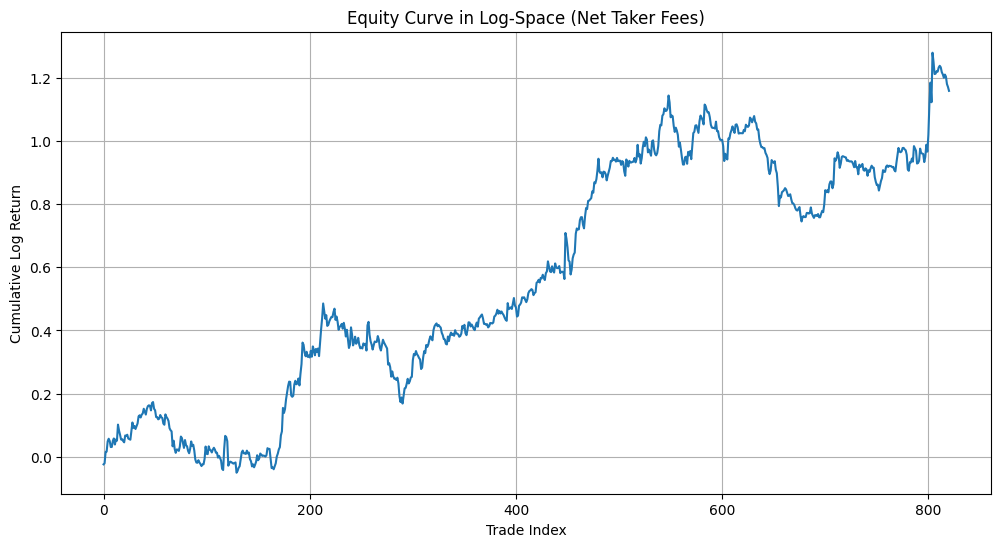

In [12]:
roundtrip_fee_log = float(np.log(1 - 2 * taker_fee))

model_trades = (
    model_trades
    .with_columns([
        pl.col("position").cast(pl.Int8).alias("pos"),
        pl.col("position").shift(1).cast(pl.Int8).alias("pos_prev"),
    ])
    .with_columns([
        (pl.col("pos") != pl.col("pos_prev"))
        .fill_null(True)
        .alias("is_flip"),
    ])
    .with_columns([
        pl.when(pl.col("is_flip"))
          .then(pl.lit(roundtrip_fee_log))
          .otherwise(pl.lit(0.0))
          .alias("fee_log"),
    ])
    .with_columns([
        (pl.col("trade_log_return") + pl.col("fee_log"))
        .alias("trade_log_return_net_taker"),
    ])
    .with_columns([
        pl.col("trade_log_return_net_taker")
        .cum_sum()
        .alias("equity_curve_net_taker"),
    ])
)

# -------------------------
# 3) Sanity check
# -------------------------
print(
    model_trades.select([
        pl.col("is_flip").mean().alias("flip_rate"),
        pl.col("trade_log_return").mean().alias("mean_gross"),
        pl.col("trade_log_return_net_taker").mean().alias("mean_net"),
    ])
)

# -------------------------
# 4) Plot
# -------------------------
import matplotlib.pyplot as plt
import numpy as np

eq = model_trades["equity_curve_net_taker"].to_numpy()

plt.figure(figsize=(12,6))
plt.plot(eq)
plt.title("Equity Curve in Log-Space (Net Taker Fees)")
plt.xlabel("Trade Index")
plt.ylabel("Cumulative Log Return")
plt.grid(True)
plt.show()

In [13]:
r_net = model_trades["trade_log_return"].to_numpy()

N = len(r_net)
mean_r = r_net.mean()
std_r = r_net.std(ddof=1)

t_stat = mean_r / (std_r / np.sqrt(N))

print("----- GROSS PERFORMANCE -----")
print("N:", N)
print("Mean per bar:", mean_r)
print("Std per bar:", std_r)
print("t-stat:", t_stat)

----- GROSS PERFORMANCE -----
N: 821
Mean per bar: 0.0018427734
Std per bar: 0.020714467
t-stat: 2.548999455679184


In [14]:
bars_per_year = 3 * 365

ann_ret = mean_r * bars_per_year
ann_vol = std_r * np.sqrt(bars_per_year)

sharpe = ann_ret / ann_vol

print("Annualized Return:", ann_ret)
print("Annualized Vol:", ann_vol)
print("Sharpe:", sharpe)

Annualized Return: 2.0178368
Annualized Vol: 0.6854579705878996
Sharpe: 2.9437790437066167


In [15]:
r_net = model_trades["trade_log_return_net_taker"].to_numpy()

N = len(r_net)
mean_r = r_net.mean()
std_r = r_net.std(ddof=1)

t_stat = mean_r / (std_r / np.sqrt(N))

print("----- NET PERFORMANCE -----")
print("N:", N)
print("Mean per bar:", mean_r)
print("Std per bar:", std_r)
print("t-stat:", t_stat)

----- NET PERFORMANCE -----
N: 821
Mean per bar: 0.0014106666586081516
Std per bar: 0.020699574458065202
t-stat: 1.9526956692259168


In [16]:
bars_per_year = 3 * 365

ann_ret = mean_r * bars_per_year
ann_vol = std_r * np.sqrt(bars_per_year)

sharpe = ann_ret / ann_vol

print("Annualized Return:", ann_ret)
print("Annualized Vol:", ann_vol)
print("Sharpe:", sharpe)

Annualized Return: 1.544679991175926
Annualized Vol: 0.6849651517455169
Sharpe: 2.255122012031667


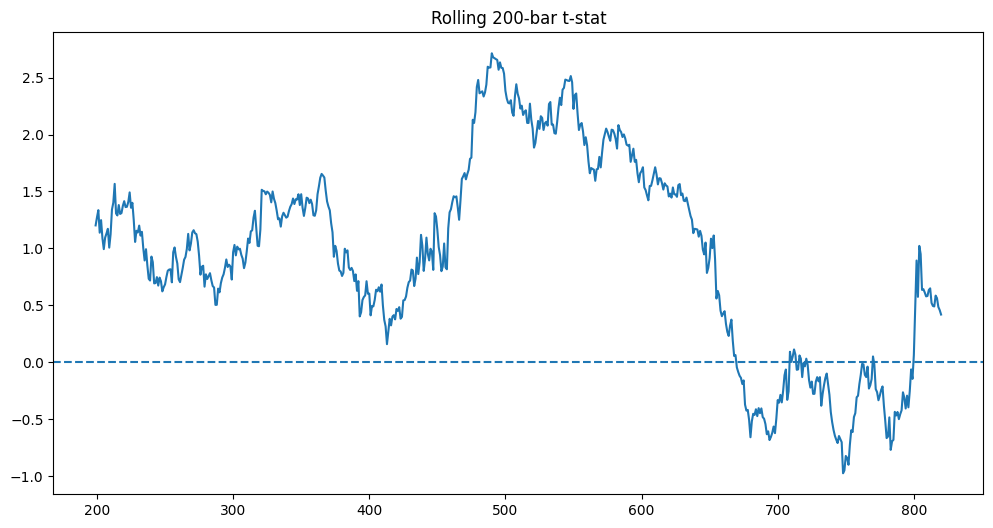

In [17]:
import pandas as pd

r_series = pd.Series(r_net)

rolling_t = (
    r_series.rolling(200)
    .apply(lambda x: x.mean() / (x.std(ddof=1) / np.sqrt(len(x))), raw=False)
)

plt.figure(figsize=(12,6))
plt.plot(rolling_t)
plt.axhline(0, linestyle='--')
plt.title("Rolling 200-bar t-stat")
plt.show()

📈 Rolling 200-Bar t-Statistic (Net Returns)

To assess whether the strategy’s edge is stable over time, we compute a rolling 200-bar t-statistic of the net log returns:

$$
t_{roll}(t) = \frac{\bar{r}{t-199:t}}{s{t-199:t} / \sqrt{200}}
$$

Where:
	•	$ \bar{r}_{t-199:t} $ = mean net log return over the last 200 bars
	•	$ s_{t-199:t} $ = standard deviation over the same window
	•	$ 200 $ = rolling window length

This measures local statistical significance, not just full-sample performance.

⸻

🎯 Why This Matters

The full-sample t-stat assumes:

$$
\mathbb{E}[r_t] = \mu \quad \text{is constant over time}
$$

But financial markets are rarely stationary.
Edges tend to be regime-dependent and time-varying.

The rolling t-stat answers a more realistic question:

“If I had only seen the last 200 bars at any point in time, would I believe this strategy has predictive power?”

⸻

🔎 What the Plot Shows

From the rolling t-stat:
	•	Extended periods where
$$
t_{roll} > 2
$$
→ Strong local statistical significance
	•	Periods where
$$
t_{roll} \approx 0
$$
→ No clear edge
	•	Some windows where
$$
t_{roll} < 0
$$
→ Temporary underperformance

This indicates the strategy is not uniformly strong across time, but rather:
	•	Persistent overall
	•	Fluctuating in strength
	•	Likely regime-sensitive

⸻

🧠 Important Interpretation

A positive full-sample t-stat (e.g., $t \approx 1.95$ net) does not imply consistent profitability.

The rolling analysis shows:
	•	The edge is distributed across time, not concentrated in a single short burst.
	•	There is no single isolated spike responsible for all performance.
	•	Performance weakens mid-sample but later partially recovers.

This is a healthier structure than a strategy whose entire Sharpe comes from one short lucky period.

⸻

📌 Takeaway

We are not just asking:

“Does this strategy make money?”

We are asking:

“Does this strategy exhibit persistent statistical structure over time?”

The rolling t-stat suggests:
	•	There is signal
	•	It is time-varying
	•	It is not purely random
	•	But it is not perfectly stable either

Which is exactly what we expect in real markets.

In [18]:
r = model_trades["trade_log_return_net_taker"].to_numpy()

mid = len(r)//2

r1 = r[:mid]
r2 = r[mid:]

def compute_t(x):
    return x.mean() / (x.std(ddof=1) / np.sqrt(len(x)))

print("First half t:", compute_t(r1))
print("Second half t:", compute_t(r2))

First half t: 1.3162864133664136
Second half t: 1.4442034523986105


To verify whether the strategy’s performance is concentrated in a specific subperiod, we split the net returns into two equal halves:
	•	First half: $r_1$
	•	Second half: $r_2$

For each subsample, we compute the t-statistic:

$$
t = \frac{\bar{r}}{s / \sqrt{N}}
$$

Where:
	•	$\bar{r}$ = mean net log return
	•	$s$ = sample standard deviation
	•	$N$ = number of observations

📊 Results
	•	First half t-stat: 1.32
	•	Second half t-stat: 1.44

⸻

🎯 Interpretation

If the strategy’s edge were driven by a single lucky regime, we would expect something like:
	•	Strong t-stat in one half
	•	Near-zero or negative t-stat in the other

Instead, both halves show moderately positive and similar t-statistics.

This suggests:
	•	The signal is not concentrated in one specific time window
	•	Performance is relatively distributed across the sample
	•	The edge is not purely regime-isolated

⸻

🧠 What This Means

While neither half individually shows very strong statistical significance, the fact that both halves remain positive indicates:
	•	Temporal consistency
	•	No obvious structural breakdown between early and late periods
	•	A more stable behavior than a regime-only strategy

This strengthens the case that the observed performance is not purely the result of one favorable market phase.

In [19]:
r = model_trades["trade_log_return_net_taker"].to_numpy()
signal = model_trades["position"].to_numpy()

np.random.seed(42)
signal_shuffled = np.random.permutation(signal)

r_fake = signal_shuffled * model_trades["trade_log_return"].to_numpy()

compute_t(r_fake)

np.float64(0.44402134923920655)

🔀 Shuffled Signal Test (Random Alignment Diagnostic)

To verify that the strategy’s performance comes from predictive structure, and not from unconditional drift in returns, we perform a shuffled signal test.

We randomly permute the trading signals while keeping the realized returns unchanged:

$$
r^{fake}_t = \tilde{s}_t \cdot r_t
$$

Where:
	•	$\tilde{s}_t$ = randomly permuted signal
	•	$r_t$ = realized log return

We then compute the t-statistic of the shuffled strategy.

📊 Result

Shuffled t-stat:

$$
t_{shuffled} \approx 0.44
$$

⸻

🎯 Interpretation

If the strategy’s performance were due to:
	•	A structural upward drift in returns
	•	A bias in long exposure
	•	Or pure randomness

Then shuffling the signals would not significantly reduce the t-stat.

However, we observe:

$$
t_{original} \approx 1.95
$$

vs.

$$
t_{shuffled} \approx 0.44
$$

This indicates that:
	•	The alignment between signals and future returns matters.
	•	Predictive structure is present.
	•	The edge is not merely coming from unconditional mean returns.

⸻

🧠 Why This Test Is Important

The t-statistic depends only on:

$$
t = \frac{\bar{r}}{s / \sqrt{N}}
$$

It does not account for temporal ordering.

By shuffling the signals, we destroy any systematic alignment between predictions and outcomes.

Since the t-stat collapses toward zero, this supports the hypothesis that:

The model is capturing real, though weak, predictive information.

⸻

📌 Takeaway

The shuffled signal test acts as a basic but powerful robustness check:
	•	If performance survives shuffling → likely random
	•	If performance disappears after shuffling → signal alignment matters

In our case, the edge weakens substantially under randomization, suggesting the strategy is not purely noise.

### RECAP

At this stage, we have performed multiple structural validation checks on the strategy.

1️⃣ Full-Sample Performance

Net performance:
	•	$t \approx 1.95$
	•	Sharpe ≈ 2.25
	•	Positive mean net return after taker fees

This suggests the presence of statistical edge in the full out-of-sample period.

However, a single full-sample t-stat is not sufficient to claim robustness.

⸻

2️⃣ Rolling 200-Bar t-Statistic

We computed:

$$
t_{roll}(t) = \frac{\bar{r}{t-199:t}}{s{t-199:t} / \sqrt{200}}
$$

This revealed:
	•	Extended periods of local significance ($t > 2$)
	•	Periods of weaker performance
	•	No single isolated spike dominating the entire result

Interpretation:

The edge is time-varying but persistent, not concentrated in one short lucky window.

⸻

3️⃣ Subsample Stability (Half-Split Test)

We split the net returns into two equal halves and computed:
	•	First half: $t \approx 1.32$
	•	Second half: $t \approx 1.44$

This indicates:
	•	Performance is distributed across time
	•	No obvious structural collapse in the later period
	•	The edge is not driven by one regime only

⸻

4️⃣ Shuffled Signal Test

We randomized signal alignment:

$$
r^{fake}_t = \tilde{s}_t \cdot r_t
$$

Result:

$$
t_{shuffled} \approx 0.44
$$

Since:

$$
t_{original} \gg t_{shuffled}
$$

This suggests:
	•	Predictive alignment matters
	•	The edge is not purely unconditional drift
	•	There is real (though weak) predictive structure

⸻

📌 What Has Been Validated

So far, we have evidence that:
	•	The strategy has positive net expectancy
	•	The edge is not concentrated in one short regime
	•	Signal alignment contributes meaningfully
	•	Performance survives realistic taker fees

⸻

⚠ What Has NOT Been Validated Yet

We have not yet tested:
	•	Stability under rolling retraining
	•	Parameter sensitivity across time
	•	Structural decay under walk-forward evaluation
	•	Out-of-sample performance under multiple re-optimizations

Currently, the model has been trained once and evaluated once.

That is not sufficient for deployment-level confidence.

shape: (10, 8)
┌───────────┬───────────┬───────────┬──────────┬───────────┬───────────┬─────────────┬─────────────┐
│ window_id ┆ start_idx ┆ train_len ┆ test_len ┆ t_stat    ┆ max_dd    ┆ final_equit ┆ mean_turnov │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆ ---       ┆ ---       ┆ y           ┆ er          │
│ i64       ┆ i64       ┆ i64       ┆ i64      ┆ f64       ┆ f64       ┆ ---         ┆ ---         │
│           ┆           ┆           ┆          ┆           ┆           ┆ f64         ┆ f64         │
╞═══════════╪═══════════╪═══════════╪══════════╪═══════════╪═══════════╪═════════════╪═════════════╡
│ 0         ┆ 0         ┆ 1200      ┆ 200      ┆ -2.516503 ┆ -0.754852 ┆ 0.243872    ┆ 2.11        │
│ 1         ┆ 200       ┆ 1200      ┆ 200      ┆ 0.233067  ┆ -0.402432 ┆ 1.126814    ┆ 1.79        │
│ 2         ┆ 400       ┆ 1200      ┆ 200      ┆ 1.271186  ┆ -0.298706 ┆ 2.352423    ┆ 1.67        │
│ 3         ┆ 600       ┆ 1200      ┆ 200      ┆ 1.701211  ┆ -0.475398 ┆ 5.9

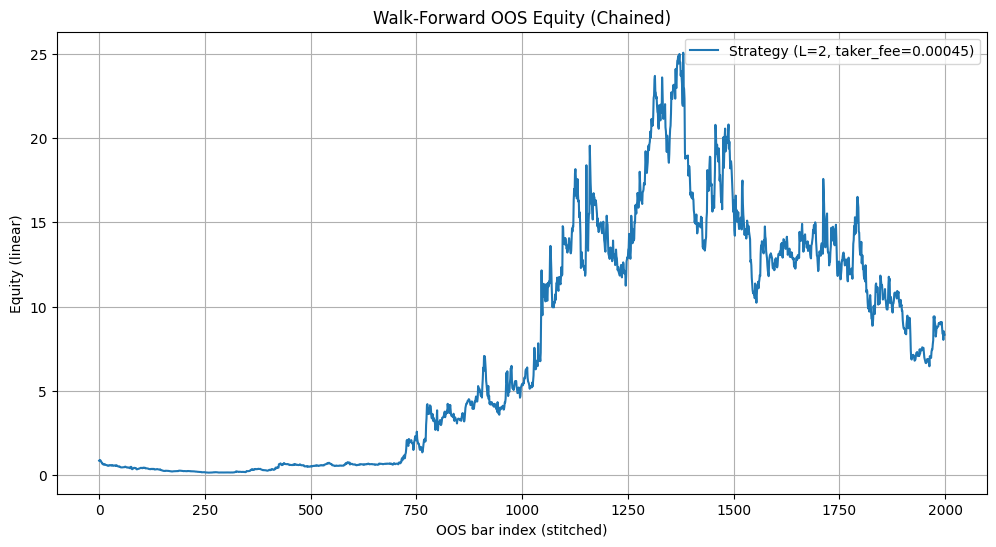

In [20]:
import numpy as np
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ----------------------------
# Walk-forward settings
# ----------------------------
features = [
    "close_log_return_lag_1",
    "close_log_return_lag_2",
    "close_log_return_lag_3",
    "close_log_return_lag_5",
]
target = "close_log_return"

taker_fee = 0.00045
L = 2.0

no_epochs = 200
lr = 5e-4

# window sizes in bars (8h bars):
train_len = 1200
test_len  = 200
step_len  = 200

# ----------------------------
# Helpers
# ----------------------------
def compute_t(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    if len(x) < 2:
        return np.nan
    s = x.std(ddof=1)
    if s == 0 or np.isnan(s):
        return np.nan
    return x.mean() / (s / np.sqrt(len(x)))

def max_drawdown_from_equity(equity: np.ndarray) -> float:
    peak = np.maximum.accumulate(equity)
    dd = equity / peak - 1.0
    return float(dd.min())

def train_linear_model(X_train, y_train, input_dim, no_epochs=200, lr=5e-4):
    model = LinearModel(input_dim)
    if hasattr(research, "init_weights"):
        model.apply(research.init_weights)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for _ in range(no_epochs):
        y_hat = model(X_train)
        loss = criterion(y_hat, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

def build_strategy(df: pl.DataFrame, taker_fee: float, L: float) -> pl.DataFrame:
    """
    Exposure: w_t = L * position_t, with position_t in {-1,+1}.
    Turnover: |Δw_t| = |w_t - w_{t-1}|, starting from w_{-1}=0.
    Fee fraction per bar: fee_frac_t = taker_fee * |Δw_t|
    Per-bar log equity increment:
        log_ret_t = w_t * r_t + log(1 - fee_frac_t)
    where r_t is the realized log return (y_true).
    """
    pos = df["position"].to_numpy().astype(float)      # +/-1
    r   = df["y_true"].to_numpy().astype(float)        # realized log-return per bar

    w = L * pos
    w_prev = np.concatenate([[0.0], w[:-1]])
    turnover = np.abs(w - w_prev)                      # |Δw|
    fee_frac = taker_fee * turnover                    # fraction of equity paid
    fee_frac = np.clip(fee_frac, 0.0, 0.99)            # safety

    log_ret = w * r + np.log(1.0 - fee_frac)
    eq = np.exp(np.cumsum(log_ret))

    return df.with_columns([
        pl.Series("w", w),
        pl.Series("turnover", turnover),
        pl.Series("fee_frac", fee_frac),
        pl.Series("log_ret", log_ret),
        pl.Series("equity", eq),
        pl.Series("log_equity", np.log(eq)),
    ])

# ----------------------------
# Data prep (keep datetime if available; otherwise it will just be omitted)
# ----------------------------
base_cols = [c for c in ["datetime"] if c in ts.columns]
df = ts.drop_nulls(subset=features + [target]).select(base_cols + features + [target])

N = df.height
assert N >= train_len + test_len, "Not enough data for your chosen window sizes."

# ----------------------------
# Walk-forward loop
# ----------------------------
windows = []
stitched = []

start = 0
w_id = 0

while start + train_len + test_len <= N:
    train = df.slice(start, train_len)
    test  = df.slice(start + train_len, test_len)

    X_train = torch.tensor(train.select(features).to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(train.select([target]).to_numpy(), dtype=torch.float32)  # (N,1)

    X_test  = torch.tensor(test.select(features).to_numpy(), dtype=torch.float32)
    y_test  = test.select([target]).to_numpy().reshape(-1).astype(np.float32)

    model = train_linear_model(X_train, y_train, input_dim=len(features), no_epochs=no_epochs, lr=lr)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).detach().cpu().numpy().reshape(-1).astype(np.float32)

    oos_dict = {
        "window_id": np.full(len(y_pred), w_id, dtype=int),
        "bar_in_window": np.arange(len(y_pred), dtype=int),
        "y_pred": y_pred,
        "y_true": y_test,
    }
    if "datetime" in test.columns:
        oos_dict["datetime"] = test["datetime"].to_numpy()

    oos = pl.DataFrame(oos_dict).with_columns([
        pl.col("y_pred").sign().alias("position"),
        (pl.col("y_pred").sign() * pl.col("y_true")).alias("trade_log_return"),
    ])

    oosS = build_strategy(oos, taker_fee=taker_fee, L=L)

    r = oosS["log_ret"].to_numpy()
    eq = oosS["equity"].to_numpy()

    windows.append({
        "window_id": w_id,
        "start_idx": start,
        "train_len": train_len,
        "test_len": test_len,
        "t_stat": compute_t(r),
        "max_dd": max_drawdown_from_equity(eq),
        "final_equity": float(eq[-1]),
        "mean_turnover": float(oosS["turnover"].mean()),
    })

    stitched.append(oosS)

    start += step_len
    w_id += 1

wf_metrics = pl.DataFrame(windows)
wf_oos = pl.concat(stitched, how="vertical")

print(wf_metrics)

# ----------------------------
# Stitch equity across windows (chain per-window returns)
# ----------------------------
wf_oos = wf_oos.with_columns(
    pl.col("equity").shift(1).over("window_id").alias("eq_prev")
).with_columns(
    (pl.col("equity") / pl.col("eq_prev")).fill_null(pl.col("equity")).alias("mult")
).drop("eq_prev")

mult = wf_oos["mult"].to_numpy()
equity_chained = np.cumprod(mult)

wf_oos = wf_oos.with_columns(pl.Series("equity_chained", equity_chained))

# ----------------------------
# Sanity check (must match)
# ----------------------------
r_all = wf_oos["log_ret"].to_numpy()
print("\nSanity: exp(sum(log_ret)) vs chained end:",
      float(np.exp(r_all.sum())),
      float(wf_oos["equity_chained"][-1]))

# ----------------------------
# Plot chained OOS equity
# ----------------------------
plt.figure(figsize=(12, 6))
plt.plot(wf_oos["equity_chained"].to_numpy(), label=f"Strategy (L={L:g}, taker_fee={taker_fee:g})")
plt.title("Walk-Forward OOS Equity (Chained)")
plt.xlabel("OOS bar index (stitched)")
plt.ylabel("Equity (linear)")
plt.grid(True)
plt.legend()
plt.show()

Walk-Forward Validation (stitched OOS) with Leverage + Taker Fees

We evaluate the strategy using walk-forward validation:
	•	Each fold trains on 1200 bars (~400 days with 8h bars),
	•	then tests on the next 200 bars (~66 days),
	•	and we roll forward by 200 bars (non-overlapping OOS folds).
	•	Finally, we stitch (chain) all OOS folds into one long equity curve.

Signal and per-bar PnL
The model outputs a continuous prediction $\hat{y}_t$. We trade only its sign:
	•	Position: $s_t = \mathrm{sign}(\hat{y}_t) \in {-1,+1}$
	•	Realized log return of the asset during bar $t$: $r_t$ (this is y_true)
	•	Exposure with leverage: $w_t = L \cdot s_t$

So the gross log-return contribution per bar is:
$$
\ell^{gross}_t = w_t , r_t
$$

Fees (taker, proportional to turnover)
For perpetual futures, the taker fee is paid on traded notional. We approximate this by charging a fee proportional to turnover in exposure:
	•	Turnover: $| \Delta w_t | = |w_t - w_{t-1}|$, with $w_{-1}=0$ (start flat)
	•	Fee fraction of equity:
$$
\mathrm{fee_frac}_t = \mathrm{taker_fee},|\Delta w_t|
$$

We apply the fee multiplicatively on equity, which becomes additive in log-space:
$$
E_{t+1} = E_t \exp(w_t r_t)\left(1 - \mathrm{fee_frac}_t\right)
$$

And the equity path is:
$$
E_t = \exp!\left(\sum_{i=0}^{t} \ell_i\right)
$$

This is exactly what the code implements via log_ret and equity.

⸻

Interpreting the outputs

1) The sanity check passed
The line

exp(sum(log_ret)) vs chained end: 8.333... 8.333...

confirms the core accounting identity:
$$
E_{final} = \exp!\left(\sum_t \ell_t\right)
$$
So chaining + log returns are internally consistent.

2) Why can equity become very large (peaks near ~25x)?
Compounding in log space is powerful: even a small positive average $\mathbb{E}[\ell_t]$ over 2000 bars can produce a large final multiple because:
$$
E_{final} = \exp!\left(\sum_{t=1}^{2000} \ell_t\right)
$$

But this comes with the other side of the coin: the same compounding + leverage also makes drawdowns and volatility explode when performance turns negative.

3) Fold table (wf_metrics) shows regime dependence
Each row is one OOS fold (200 bars). A few key takeaways:
	•	Some windows have strongly negative $t$-stats (e.g., window 0: $t=-2.52$), meaning the strategy lost money in that regime.
	•	Other windows have positive $t$-stats (e.g., window 3: $t=1.70$) and produce large equity growth inside that fold.
	•	This is typical for crypto: performance is not stable across regimes.

Also note: with only 200 observations per fold, the fold-level $t$-stat is quite noisy (useful as a rough diagnostic, not as “proof”).

4) Turnover is very high (fees matter a lot)
mean_turnover is around 1.6–2.1.

Because $w_t \in {-2,+2}$:
	•	staying same side: $|Δw|=0$
	•	going flat → position: $|Δw|=2$
	•	flipping long ↔ short: $|Δw|=4$

So average turnover near ~2 implies you are changing exposure very often (lots of entry/exit and flips), which makes fees a first-order driver of results.

⸻

Quick “red-flag” check to keep in mind

This plot peaks high but ends much lower, and fold max drawdowns are large (some > −75% inside a 200-bar fold). That combination usually means:
	•	the strategy can compound fast in favorable regimes,
	•	but is fragile and can give back a lot when the regime changes,
	•	and the high turnover makes the edge sensitive to small modeling/fee/slippage errors.

In [21]:
R_COL = "log_ret"

# ---- per-fold (per window_id) stats ----
fold_stats = (
    wf_oos
    .group_by("window_id")
    .agg([
        pl.len().alias("n"),
        pl.col(R_COL).mean().alias("mean_ret_bar"),
        pl.col(R_COL).std(ddof=1).alias("std_ret_bar"),
        pl.col(R_COL).sum().alias("sum_logret"),
        (pl.col(R_COL).sum().exp()).alias("final_equity"),
    ])
    .with_columns([
        (pl.col("sum_logret") > 0).alias("positive_fold"),
        (pl.col("final_equity") > 1.0).alias("profitable_fold"),
    ])
    .sort("window_id")
)

print(fold_stats)

# 1) mean of returns across all folds (equal-weight each fold)
mean_of_fold_means = fold_stats.select(pl.col("mean_ret_bar").mean().alias("mean_of_fold_means"))

# 2) average EV across all folds (same idea: equal-weight by fold)
# (EV per fold = sum_logret; EV per bar = mean_ret_bar)
avg_EV_per_fold = fold_stats.select(pl.col("sum_logret").mean().alias("avg_EV_sumlogret_per_fold"))
avg_EV_per_bar  = fold_stats.select(pl.col("mean_ret_bar").mean().alias("avg_EV_per_bar_equal_weight"))

# 3) how many folds have positive returns
counts = fold_stats.select([
    pl.len().alias("n_folds"),
    pl.col("positive_fold").sum().alias("n_folds_sumlogret_pos"),
    pl.col("profitable_fold").sum().alias("n_folds_finaleq_gt1"),
    pl.col("positive_fold").mean().alias("pct_folds_sumlogret_pos"),
    pl.col("profitable_fold").mean().alias("pct_folds_finaleq_gt1"),
])

print("\n=== Across-fold summaries (equal-weight by fold) ===")
print(mean_of_fold_means)
print(avg_EV_per_fold)
print(avg_EV_per_bar)
print(counts)

# ---- sanity / alternative: bar-weighted EV (uses ALL bars, not equal-weight folds) ----
# if all folds have same length (200), this equals the equal-weight mean_ret_bar above.
bar_weighted_ev = float(wf_oos[R_COL].mean())
print("\nEV per bar (bar-weighted, all bars):", bar_weighted_ev)

shape: (10, 8)
┌───────────┬─────┬─────────────┬─────────────┬────────────┬─────────────┬────────────┬────────────┐
│ window_id ┆ n   ┆ mean_ret_ba ┆ std_ret_bar ┆ sum_logret ┆ final_equit ┆ positive_f ┆ profitable │
│ ---       ┆ --- ┆ r           ┆ ---         ┆ ---        ┆ y           ┆ old        ┆ _fold      │
│ i64       ┆ u32 ┆ ---         ┆ f64         ┆ f64        ┆ ---         ┆ ---        ┆ ---        │
│           ┆     ┆ f64         ┆             ┆            ┆ f64         ┆ bool       ┆ bool       │
╞═══════════╪═════╪═════════════╪═════════════╪════════════╪═════════════╪════════════╪════════════╡
│ 0         ┆ 200 ┆ -0.007056   ┆ 0.03965     ┆ -1.411111  ┆ 0.243872    ┆ false      ┆ false      │
│ 1         ┆ 200 ┆ 0.000597    ┆ 0.036223    ┆ 0.119394   ┆ 1.126814    ┆ true       ┆ true       │
│ 2         ┆ 200 ┆ 0.004277    ┆ 0.047585    ┆ 0.855446   ┆ 2.352423    ┆ true       ┆ true       │
│ 3         ┆ 200 ┆ 0.008923    ┆ 0.074175    ┆ 1.784549   ┆ 5.95689     ┆ t

In [22]:
import numpy as np

# --- basic fold counts ---
n_folds = fold_stats.height
n_positive = int(fold_stats["positive_fold"].sum())
pct_positive = n_positive / n_folds

# --- equal-weight EV across folds ---
mean_of_fold_means = float(fold_stats["mean_ret_bar"].mean())
mean_sum_logret = float(fold_stats["sum_logret"].mean())
mean_final_equity = float(fold_stats["final_equity"].mean())

# --- bar-weighted EV (all bars) ---
ev_bar_weighted = float(wf_oos["log_ret"].mean())

print("\n========== CLEAN SUMMARY ==========")
print(f"Number of folds: {n_folds}")
print(f"Profitable folds: {n_positive}/{n_folds} ({pct_positive:.2%})")
print("\nEqual-weight across folds:")
print(f"Mean return per bar (avg of fold means): {mean_of_fold_means:.6f}")
print(f"Mean sum log-return per fold: {mean_sum_logret:.6f}")
print(f"Mean final equity per fold: {mean_final_equity:.4f}")
print("\nBar-weighted EV (all bars pooled):")
print(f"EV per bar: {ev_bar_weighted:.6f}")
print("====================================\n")


========== CLEAN SUMMARY ==========
Number of folds: 10
Profitable folds: 7/10 (70.00%)

Equal-weight across folds:
Mean return per bar (avg of fold means): 0.001060
Mean sum log-return per fold: 0.212024
Mean final equity per fold: 1.7405

Bar-weighted EV (all bars pooled):
EV per bar: 0.001060



Cross-Fold Performance Summary

We now aggregate results across the 10 walk-forward OOS folds (each 200 bars).

1️⃣ Number of folds
	•	Total folds: 10
	•	Profitable folds: 7 / 10 (70%)

A fold is considered profitable if:
$$
\sum_{t \in \text{fold}} \ell_t > 0
\quad \Longleftrightarrow \quad
E_{\text{final}} > 1
$$

So the strategy generates positive net performance in the majority of regimes, although not all.

⸻

2️⃣ Expected value (EV) per bar
Equal-weight across folds:
$$
\text{EV per bar} = 0.001060
$$

Because each fold contains exactly 200 bars, the equal-weight fold average and the bar-weighted average coincide:

$$
\mathbb{E}[\ell_t] = 0.001060
$$

This means the strategy earns on average:
	•	0.106% log-return per 8-hour bar

With approximately 1095 bars per year:

$$
0.001060 \times 1095 \approx 1.16
$$

So the implied annualized expected log return is:

$$
e^{1.16} \approx 3.2\times
$$

This is strong, but must be interpreted with caution due to regime dependence and leverage.

⸻

3️⃣ Mean performance per fold
	•	Mean cumulative log-return per fold:
$$
\text{Mean } \sum \ell_t = 0.212
$$
	•	Mean final equity per fold:
$$
\overline{E_{\text{final}}} = 1.74
$$

This indicates that the typical 200-bar OOS window grows capital by roughly 74%, though the distribution is highly skewed (some folds are strongly negative).

⸻

Interpretation
	•	The edge is positive on average.
	•	70% of regimes are profitable.
	•	Performance is uneven across windows.
	•	Large positive folds contribute disproportionately to total compounded return.
	•	Drawdowns remain substantial in adverse regimes.

This confirms that the strategy has positive expected value, but it is clearly regime-dependent and volatile under leverage $L=2$.

fold_stats:
shape: (10, 11)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ window_id ┆ start_idx ┆ train_len ┆ test_len ┆ … ┆ sharpe_ne ┆ final_equ ┆ max_dd_ne ┆ mean_turn │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ t         ┆ ity_net   ┆ t         ┆ over      │
│ i64       ┆ i64       ┆ i64       ┆ i64      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│           ┆           ┆           ┆          ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0         ┆ 0         ┆ 1200      ┆ 200      ┆ … ┆ -1.023613 ┆ 0.243872  ┆ -0.754853 ┆ 2.11      │
│ 1         ┆ 200       ┆ 1200      ┆ 200      ┆ … ┆ 0.094802  ┆ 1.126814  ┆ -0.402432 ┆ 1.79      │
│ 2         ┆ 400       ┆ 1200      ┆ 200      ┆ … ┆ 0.517068  ┆ 2.352423  ┆ -0.298706 ┆ 1.67      │
│ 3         ┆ 600       ┆ 1200      ┆ 200      ┆ … ┆ 0.691985  

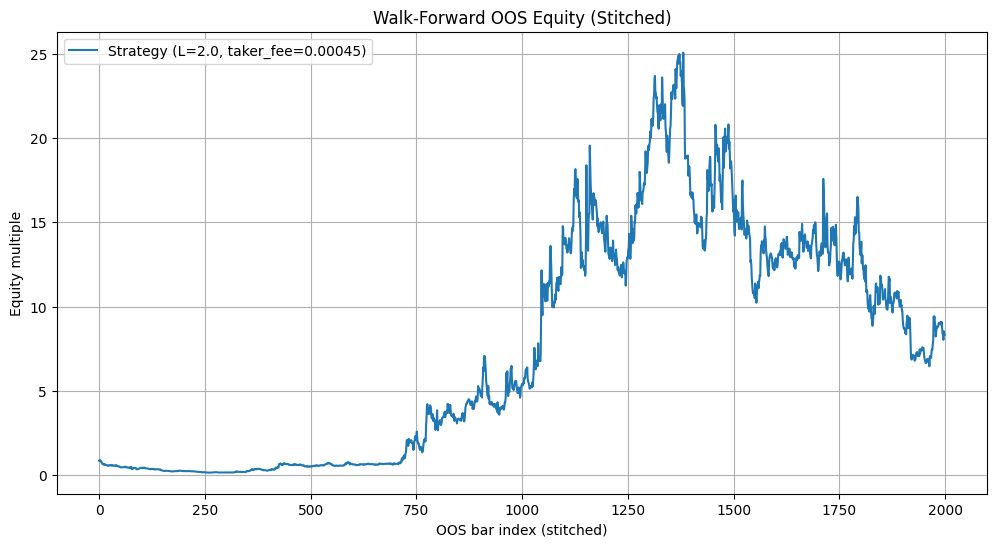

In [23]:
# ============================
# WALK-FORWARD VALIDATION (ADA-style, stitched OOS) — CONSISTENT VERSION
# - Rolling window
# - Train model each fold
# - Predict on next TEST_LEN bars
# - Position = sign(y_pred)
# - Perps-style turnover fees + leverage L
# - Stitch all OOS bars into one equity curve
# ============================

import numpy as np
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ----------------------------
# 0) Settings
# ----------------------------
TRAIN_LEN = 1200
TEST_LEN  = 200
STEP      = 200
NO_EPOCHS = 200
LR        = 5e-4

taker_fee = 0.00045
L = 2.0

# ----------------------------
# 1) Helpers
# ----------------------------

def ann_sharpe(mean_bar: float, std_bar: float, annualized_rate: float) -> float:
    if std_bar == 0 or np.isnan(std_bar):
        return np.nan
    return (mean_bar / std_bar) * np.sqrt(annualized_rate)

# ----------------------------
# 2) Data (must include datetime + features + target)
# ----------------------------
df_wf = (
    ts
    .drop_nulls(subset=features + [target])
    .select(["datetime"] + features + [target])
)

N = df_wf.height
assert N >= TRAIN_LEN + TEST_LEN, "Not enough data for chosen window sizes."

oos_chunks = []
fold_rows = []

# ----------------------------
# 3) Walk-forward loop
# ----------------------------
window_id = 0
for start in range(0, N - TRAIN_LEN - TEST_LEN + 1, STEP):
    train_df = df_wf.slice(start, TRAIN_LEN)
    test_df  = df_wf.slice(start + TRAIN_LEN, TEST_LEN)

    # tensors
    X_train = torch.tensor(train_df.select(features).to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(train_df.select([target]).to_numpy(), dtype=torch.float32)  # (N,1)

    X_test  = torch.tensor(test_df.select(features).to_numpy(), dtype=torch.float32)
    y_test  = test_df.select([target]).to_numpy().reshape(-1).astype(np.float32)

    # train
    model = train_linear_model(
        X_train, y_train,
        input_dim=len(features),
        no_epochs=NO_EPOCHS,
        lr=LR
    )

    # predict
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).detach().cpu().numpy().reshape(-1).astype(np.float32)

    # base fold df (per-bar)
    fold = pl.DataFrame({
        "datetime": test_df["datetime"].to_numpy(),
        "window_id": np.full(len(y_pred), window_id, dtype=np.int64),
        "bar_in_window": np.arange(len(y_pred), dtype=np.int64),
        "y_pred": y_pred,
        "y_true": y_test,  # realized log return for that bar
    }).with_columns([
        pl.col("y_pred").sign().alias("position"),                 # +/-1
        (pl.lit(L) * pl.col("y_pred").sign()).alias("w"),          # exposure in {-L,+L}
    ])

    # turnover-based fees + per-bar log return contribution
    # fee_frac_t = taker_fee * |w_t - w_{t-1}|
    fold = (
        fold
        .with_columns(
            pl.col("w").shift(1).fill_null(0.0).alias("w_prev")    # start flat each fold
        )
        .with_columns([
            (pl.col("w") - pl.col("w_prev")).abs().alias("turnover_frac"),
            (pl.lit(taker_fee) * (pl.col("w") - pl.col("w_prev")).abs()).alias("fee_frac"),
        ])
        .with_columns(
            pl.col("fee_frac").clip(0.0, 0.99).alias("fee_frac")
        )
        .with_columns(
            (pl.col("w") * pl.col("y_true") + (pl.lit(1.0) - pl.col("fee_frac")).log()).alias("log_ret_net")
        )
        .drop("w_prev")
    )

    # fold stats
    r = fold["log_ret_net"].to_numpy()
    mean_bar = float(r.mean())
    std_bar  = float(r.std(ddof=1)) if len(r) > 1 else np.nan
    tstat    = float(compute_t(r))
    sharpe   = float(ann_sharpe(mean_bar, std_bar, annualized_rate))

    eq_fold  = np.exp(np.cumsum(r))
    final_eq = float(eq_fold[-1])
    max_dd   = float(max_drawdown_from_equity(eq_fold))

    fold_rows.append({
        "window_id": window_id,
        "start_idx": start,
        "train_len": TRAIN_LEN,
        "test_len": TEST_LEN,
        "mean_bar_net": mean_bar,
        "std_bar_net": std_bar,
        "tstat_net": tstat,
        "sharpe_net": sharpe,
        "final_equity_net": final_eq,
        "max_dd_net": max_dd,
        "mean_turnover": float(fold["turnover_frac"].mean()),
    })

    oos_chunks.append(fold)
    window_id += 1

fold_stats = pl.DataFrame(fold_rows)

# ----------------------------
# 4) Stitch all OOS bars (global equity)
# ----------------------------
oos_trades = pl.concat(oos_chunks, how="vertical").sort("datetime")

r_all = oos_trades["log_ret_net"].to_numpy()
eq_all = np.exp(np.cumsum(r_all))

oos_trades = oos_trades.with_columns([
    pl.Series("equity_net", eq_all),
    pl.Series("log_equity_net", np.log(eq_all)),
])

print("fold_stats:")
print(fold_stats)

print("\nstitched OOS summary (NET):")
print("N:", len(r_all))
print("mean/bar:", float(r_all.mean()))
print("std/bar:", float(r_all.std(ddof=1)))
print("t-stat:", float(compute_t(r_all)))
print("sharpe:", float(ann_sharpe(float(r_all.mean()), float(r_all.std(ddof=1)), annualized_rate)))
print("final equity multiple (net):", float(eq_all[-1]))

# ----------------------------
# 5) Plot stitched OOS equity
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(eq_all, label=f"Strategy (L={L}, taker_fee={taker_fee})")
plt.title("Walk-Forward OOS Equity (Stitched)")
plt.xlabel("OOS bar index (stitched)")
plt.ylabel("Equity multiple")
plt.grid(True)
plt.legend()
plt.show()

### Walk-forward results (stitched OOS)

We run a rolling walk-forward validation with:
- Train window: 1200 bars  
- Test window: 200 bars  
- Step: 200 bars (non-overlapping OOS folds)  
- Total OOS: 10 folds × 200 bars = 2000 bars

For each OOS bar, we trade directionally using the model signal:
- Position: $\text{pos}_t = \mathrm{sign}(\hat y_t)$  
- Per-bar exposure (leverage): $w_t = L \cdot \text{pos}_t$

#### Perps-style fees (turnover-based)
Trading costs are applied when exposure changes:
$$
\Delta w_t = w_t - w_{t-1}, \qquad \text{fee\_frac}_t = \text{taker\_fee}\cdot |\Delta w_t|
$$
The fee is multiplicative on equity, which becomes additive in log-space:
$$
r^{net}_t = w_t\,r_t + \log(1-\text{fee\_frac}_t)
$$
and the stitched equity curve is:
$$
E_T = \exp\left(\sum_{t=1}^T r^{net}_t\right)
$$

#### Interpretation
The fold table shows that performance is regime-dependent: some folds compound strongly while others lose capital, with sizeable drawdowns inside folds.  
On the stitched OOS sample (2000 bars), the average log return per bar is about $0.00106$, which compounds to a final equity multiple of $\approx 8.33\times$, but the statistical strength is modest (t-stat $\approx 0.95$, annualized Sharpe $\approx 0.12$).

In [24]:
print("Mean final equity:", fold_stats["final_equity_net"].mean())
print("Median final equity:", fold_stats["final_equity_net"].median())
print("Winning folds:", (fold_stats["final_equity_net"] > 1).mean())
print("Mean t-stat:", fold_stats["tstat_net"].mean())
print("Mean Sharpe:", fold_stats["sharpe_net"].mean())

Mean final equity: 1.7404607594013215
Median final equity: 1.1291800141334534
Winning folds: 0.7
Mean t-stat: 0.1167949734640275
Mean Sharpe: 0.0475075784339986


In [25]:
acc = (oos_trades["position"].to_numpy() * oos_trades["y_true"].to_numpy()) > 0
print("Directional accuracy OOS:", acc.mean())

Directional accuracy OOS: 0.4785


In [26]:
print("Mean EV across folds:", fold_stats["mean_bar_net"].mean())
print("Median EV across folds:", fold_stats["mean_bar_net"].median())
print("Positive EV folds:", (fold_stats["mean_bar_net"] > 0).mean())

Mean EV across folds: 0.0010601196932839229
Median EV across folds: 0.0006074477569200099
Positive EV folds: 0.7


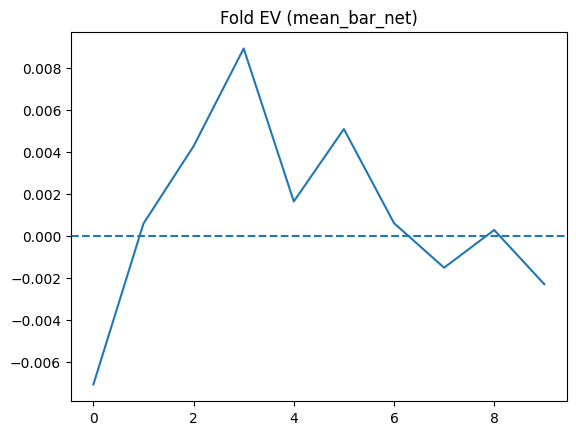

In [27]:
plt.plot(fold_stats["mean_bar_net"].to_numpy())
plt.axhline(0, linestyle="--")
plt.title("Fold EV (mean_bar_net)")
plt.show()

In [28]:
recent_folds = fold_stats.filter(pl.col("window_id") >= 6)

print("Recent mean EV:", recent_folds["mean_bar_net"].mean())
print("Recent positive rate:", (recent_folds["mean_bar_net"] > 0).mean())

Recent mean EV: -0.0007204666253528558
Recent positive rate: 0.5


## No-Trade Zone (Threshold) Experiment — Methodology

After building the stitched walk-forward OOS equity curve, we introduce a **confidence filter** on the model signal.

Instead of trading every bar, we trade only when the model output is strong enough.

---

### 1️⃣ Signal Threshold

For each OOS bar:

- Model prediction: $\hat{y}_t$
- Realized log return: $r_t$

We define a threshold $\tau$ and trade only when:

$$
|\hat{y}_t| > \tau
$$

Position becomes:

$$
\text{pos}_t =
\begin{cases}
\mathrm{sign}(\hat{y}_t) & \text{if } |\hat{y}_t| > \tau \\
0 & \text{otherwise}
\end{cases}
$$

So the strategy can be:

- Long (+1)
- Short (-1)
- Flat (0)

---

### 2️⃣ Leverage

Exposure per bar:

$$
w_t = L \cdot \text{pos}_t
$$

where $L$ is the leverage used in the previous walk-forward experiment.

---

### 3️⃣ Perpetual Futures Fee Model (Turnover-Based)

We use a **perps-style turnover fee**, consistent with the stitched walk-forward test.

Turnover per bar:

$$
\Delta w_t = w_t - w_{t-1}
$$

Fee fraction applied to equity:

$$
\text{fee\_frac}_t = \text{taker\_fee} \cdot |\Delta w_t|
$$

This captures:
- Long → Short flips
- Flat → Long
- Long → Flat

---

### 4️⃣ Net Log Return

Fees are multiplicative in equity, additive in log-space:

$$
r^{net}_t = w_t \cdot r_t + \log(1 - \text{fee\_frac}_t)
$$

Cumulative stitched equity:

$$
E_T = \exp\left(\sum_{t=1}^{T} r^{net}_t\right)
$$

---

### 5️⃣ Threshold Grid

Thresholds are chosen data-driven using percentiles of:

$$
|\hat{y}_t|
$$

This ensures:
- Low $\tau$ → trade almost always  
- High $\tau$ → trade only high-confidence signals  

---

### Goal of This Experiment

We are testing whether:

- The signal is stronger when the model is more confident.
- Avoiding weak signals improves:
  - Sharpe ratio
  - t-statistic
  - Drawdown
  - Net performance after fees.

If performance improves with moderate $\tau$, it suggests:
> The model contains useful ranking information in prediction magnitude.

If performance deteriorates quickly:
> The signal may be mostly directional noise.

shape: (9, 8)
┌──────────┬─────────────┬────────────┬──────────┬──────────┬────────────┬────────────┬────────────┐
│ tau      ┆ in_market_r ┆ mean_turno ┆ mean_net ┆ t_net    ┆ sharpe_net ┆ final_eq_n ┆ max_dd_log │
│ ---      ┆ ate         ┆ ver        ┆ ---      ┆ ---      ┆ ---        ┆ et         ┆ _net       │
│ f64      ┆ ---         ┆ ---        ┆ f64      ┆ f64      ┆ f64        ┆ ---        ┆ ---        │
│          ┆ f64         ┆ f64        ┆          ┆          ┆            ┆ f64        ┆ f64        │
╞══════════╪═════════════╪════════════╪══════════╪══════════╪════════════╪════════════╪════════════╡
│ 0.026621 ┆ 0.3         ┆ 0.828      ┆ 0.00158  ┆ 1.940091 ┆ 0.249552   ┆ 23.578865  ┆ -0.534349  │
│ 0.036003 ┆ 0.2         ┆ 0.558      ┆ 0.001438 ┆ 1.921706 ┆ 0.247187   ┆ 17.74881   ┆ -0.403882  │
│ 0.01613  ┆ 0.5         ┆ 1.25       ┆ 0.001635 ┆ 1.755281 ┆ 0.22578    ┆ 26.323933  ┆ -0.629944  │
│ 0.008488 ┆ 0.7         ┆ 1.586      ┆ 0.001487 ┆ 1.443777 ┆ 0.185711   ┆ 19

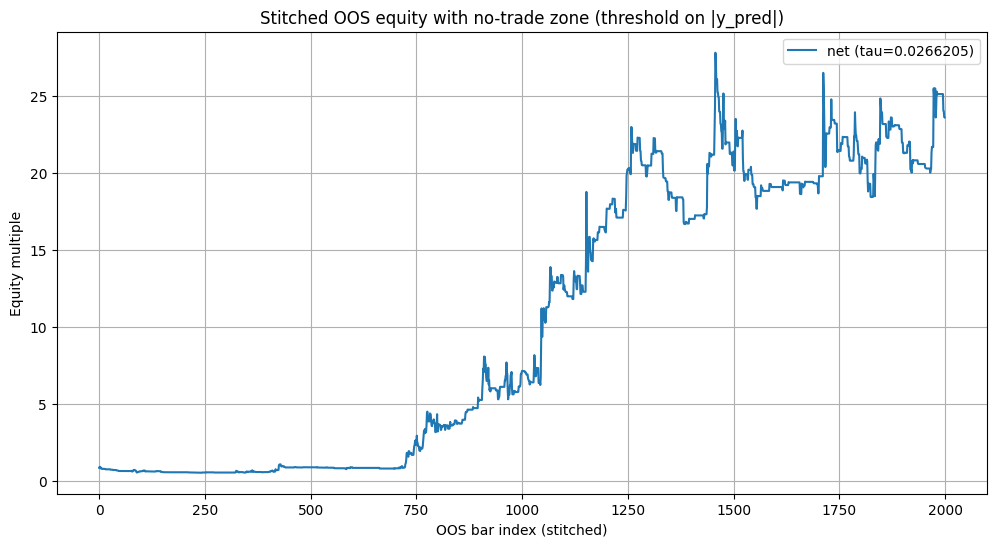


Best tau summary:
{'N': 2000, 'in_market_rate': 0.3, 'mean_turnover': 0.828, 'mean_net': 0.0015801668632775545, 't_net': 1.9400914469799138, 'sharpe_net': 0.24955183114722823, 'final_eq_net': 23.57886505126953, 'max_dd_log_net': -0.5343488454818726, 'total_fee_frac_sum': 0.745199978351593}


In [29]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

# ============================================================
# Threshold / no-trade zone on STITCHED OOS
# - Trades only when |y_pred| > tau; otherwise flat (w=0)
# - Perps-style turnover fees (consistent with your WFV):
#     fee_frac_t = taker_fee * |w_t - w_{t-1}|
#     log_ret_t  = w_t * r_t + log(1 - fee_frac_t)
# - Needs oos_trades columns: ["datetime","y_pred","y_true"] at minimum
# ============================================================


def max_dd_from_log_eq(eq_log: np.ndarray) -> float:
    peak = np.maximum.accumulate(eq_log)
    dd_log = eq_log - peak
    return float(dd_log.min())

def apply_threshold_perps_fees(oos_trades: pl.DataFrame, tau: float, taker_fee: float, L: float) -> pl.DataFrame:
    """
    Build thresholded strategy on stitched OOS, with perps-style turnover fees.

    Inputs needed in oos_trades:
      - datetime (for sorting)
      - y_pred   (model output)
      - y_true   (realized per-bar log return)
    """
    out = (
        oos_trades
        .select(["datetime", "y_pred", "y_true"])
        .sort("datetime")
        # position in {-1,0,+1}
        .with_columns(
            pl.when(pl.col("y_pred").abs() > pl.lit(float(tau)))
              .then(pl.col("y_pred").sign())
              .otherwise(pl.lit(0.0))
              .alias("position_thr")
        )
        # exposure w_t in {-L,0,+L}
        .with_columns(
            (pl.lit(float(L)) * pl.col("position_thr")).alias("w_thr")
        )
        # turnover + fees (global stitched, NOT per-window)
        .with_columns(
            pl.col("w_thr").shift(1).fill_null(0.0).alias("w_thr_prev")
        )
        .with_columns(
            (pl.col("w_thr") - pl.col("w_thr_prev")).abs().alias("turnover_frac_thr")
        )
        .with_columns(
            (pl.lit(float(taker_fee)) * pl.col("turnover_frac_thr")).alias("fee_frac_thr")
        )
        .with_columns(
            pl.col("fee_frac_thr").clip(0.0, 0.99).alias("fee_frac_thr")
        )
        # net log return contribution
        .with_columns(
            (pl.col("w_thr") * pl.col("y_true") + (pl.lit(1.0) - pl.col("fee_frac_thr")).log())
            .alias("log_ret_net_thr")
        )
        # cumulative log equity
        .with_columns(
            pl.col("log_ret_net_thr").cum_sum().alias("equity_log_net_thr")
        )
        .drop(["w_thr_prev"])
    )
    return out

def summarize_thr(tr: pl.DataFrame, annualized_rate: float) -> dict:
    r = tr["log_ret_net_thr"].to_numpy()
    eqlog = tr["equity_log_net_thr"].to_numpy()

    mean_bar = float(r.mean()) if len(r) else np.nan
    std_bar  = float(r.std(ddof=1)) if len(r) > 1 else np.nan

    return {
        "N": int(len(r)),
        "in_market_rate": float((tr["position_thr"] != 0).mean()),
        "mean_turnover": float(tr["turnover_frac_thr"].mean()),
        "mean_net": mean_bar,
        "t_net": float(compute_t(r)),
        "sharpe_net": float(ann_sharpe(mean_bar, std_bar, annualized_rate)),
        "final_eq_net": float(np.exp(eqlog[-1])) if len(eqlog) else np.nan,
        "max_dd_log_net": max_dd_from_log_eq(eqlog) if len(eqlog) else np.nan,
        "total_fee_frac_sum": float(tr["fee_frac_thr"].sum()),  # not log; just a quick diagnostic
    }

# ----------------------------
# 0) Preconditions: make sure required cols exist
# ----------------------------
required_cols = {"datetime", "y_pred", "y_true"}
missing = required_cols - set(oos_trades.columns)
if missing:
    raise ValueError(f"oos_trades is missing required columns: {sorted(missing)}")

# ----------------------------
# 1) Tau grid (percentiles of |y_pred|)
# ----------------------------
abs_pred = oos_trades.select(pl.col("y_pred").abs().alias("abs_pred"))["abs_pred"].to_numpy()
taus = np.quantile(abs_pred, [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80])

rows = []
cache = {}

for tau in taus:
    tau = float(tau)
    tr_tau = apply_threshold_perps_fees(oos_trades, tau=tau, taker_fee=taker_fee, L=L)
    cache[tau] = tr_tau
    s = summarize_thr(tr_tau, annualized_rate=annualized_rate)
    s["tau"] = tau
    rows.append(s)

res = pl.DataFrame(rows).sort("sharpe_net", descending=True)

print(res.select([
    "tau",
    "in_market_rate",
    "mean_turnover",
    "mean_net",
    "t_net",
    "sharpe_net",
    "final_eq_net",
    "max_dd_log_net",
]).head(10))

# ----------------------------
# 2) Plot best tau equity curve (NET only)
# ----------------------------
best_tau = float(res[0, "tau"])
best_tr = cache[best_tau]

eq_n = np.exp(best_tr["equity_log_net_thr"].to_numpy())

plt.figure(figsize=(12, 6))
plt.plot(eq_n, label=f"net (tau={best_tau:.6g})")
plt.title("Stitched OOS equity with no-trade zone (threshold on |y_pred|)")
plt.xlabel("OOS bar index (stitched)")
plt.ylabel("Equity multiple")
plt.grid(True)
plt.legend()
plt.show()

print("\nBest tau summary:")
print(summarize_thr(best_tr, annualized_rate=annualized_rate))

## Threshold (No-Trade Zone) Results — Interpretation

We introduce a confidence filter on the model signal by trading only when:

\[
$\hat{y}_t$ > tau
\]

and remaining flat otherwise.

This tests whether **prediction magnitude contains ranking information**, not just directional information.

---

### Key Findings

At the optimal threshold (τ ≈ 0.0266):

- **In-market rate:** 30%  
- **Mean turnover:** 0.83 (≈ 50% lower than baseline)
- **Mean log-return per bar:** 0.00158 (vs 0.00106 baseline)
- **t-stat:** 1.94 (vs 0.95 baseline)
- **Sharpe:** 0.25 (vs 0.12 baseline)
- **Final equity multiple:** 23.6× (vs 8.3× baseline)
- **Max log drawdown:** -0.53 (vs -1.78 baseline)

---

### Interpretation

1. **Signal Magnitude Contains Information**

   Higher values of $\hat{y}_t$ correspond to higher expected returns.
   Filtering out weak predictions increases average return per trade.

2. **Turnover Reduction Improves Net Performance**

   The threshold reduces:
   - Trading frequency  
   - Fee drag  
   - Noise trades  

   Lower turnover materially improves net performance.

3. **Risk Improves Significantly**

   Maximum drawdown drops dramatically.
   The equity curve becomes smoother and more stable.

4. **Monotonic Structure Across Thresholds**

   As τ increases:
   - In-market rate decreases  
   - Turnover decreases  
   - Sharpe initially increases  
   - Then performance deteriorates if τ becomes too large  

   This shape is consistent with a model that has **ranking power**.

---

### Important Caveat

The threshold τ was selected on the same stitched OOS sample.

Therefore, this result should be considered:

> A hypothesis about signal strength, not final proof of robustness.

A more rigorous approach would:
- Select τ on an earlier sub-period,
- Apply it to a later unseen period,
- And verify stability.

---

### Conclusion

The threshold experiment suggests that the model’s prediction magnitude carries economically meaningful information.

Rather than trading every signal equally, concentrating capital on high-confidence predictions significantly improves:

- Expected return
- Risk-adjusted performance
- Drawdown profile
- Fee efficiency

In [30]:
import numpy as np
import polars as pl

best_tau = float(res[0, "tau"])
best_tr = cache[best_tau]

# 1) Distribution of positions (flat / long / short)
print(
    best_tr
    .group_by("position_thr")
    .len()
    .sort("position_thr")
)

# 2) Recompute flip indicator from position_thr (or equivalently from w_thr)
best_tr_diag = (
    best_tr
    .with_columns([
        pl.col("position_thr").cast(pl.Int8).alias("pos_thr"),
        pl.col("position_thr").shift(1).cast(pl.Int8).alias("pos_thr_prev"),
    ])
    .with_columns(
        (pl.col("pos_thr") != pl.col("pos_thr_prev")).fill_null(True).alias("is_flip_thr")
    )
)

# 3) Core diagnostics (turnover / fees / EV)
print(
    best_tr_diag.select([
        pl.col("is_flip_thr").mean().alias("flip_rate"),
        (pl.col("position_thr") != 0).mean().alias("in_market_rate"),
        pl.col("turnover_frac_thr").mean().alias("mean_turnover"),
        pl.col("fee_frac_thr").mean().alias("mean_fee_frac"),
        pl.col("fee_frac_thr").sum().alias("total_fee_frac_sum"),
        pl.col("log_ret_net_thr").mean().alias("mean_logret_net"),
        pl.col("log_ret_net_thr").std(ddof=1).alias("std_logret_net"),
    ])
)

# 4) Sanity: equity last value should match exp(sum(log_ret))
eq_last = float(np.exp(best_tr_diag["equity_log_net_thr"].to_numpy()[-1]))
eq_from_sum = float(np.exp(best_tr_diag["log_ret_net_thr"].to_numpy().sum()))
print("\nSanity check equity:", {"eq_last": eq_last, "exp_sum": eq_from_sum, "diff": eq_last - eq_from_sum})

shape: (3, 2)
┌──────────────┬──────┐
│ position_thr ┆ len  │
│ ---          ┆ ---  │
│ f32          ┆ u32  │
╞══════════════╪══════╡
│ -1.0         ┆ 301  │
│ 0.0          ┆ 1400 │
│ 1.0          ┆ 299  │
└──────────────┴──────┘
shape: (1, 7)
┌───────────┬──────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┐
│ flip_rate ┆ in_market_ra ┆ mean_turnove ┆ mean_fee_fra ┆ total_fee_f ┆ mean_logret ┆ std_logret_ │
│ ---       ┆ te           ┆ r            ┆ c            ┆ rac_sum     ┆ _net        ┆ net         │
│ f64       ┆ ---          ┆ ---          ┆ ---          ┆ ---         ┆ ---         ┆ ---         │
│           ┆ f64          ┆ f32          ┆ f32          ┆ f32         ┆ f32         ┆ f32         │
╞═══════════╪══════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╡
│ 0.375     ┆ 0.3          ┆ 0.828        ┆ 0.000373     ┆ 0.7452      ┆ 0.00158     ┆ 0.036425    │
└───────────┴──────────────┴──────────────┴──────

### Thresholded strategy on stitched OOS (perps-style fees)

This block applies a **confidence filter** to the out-of-sample (stitched) predictions and then recomputes a realistic PnL stream under a **perpetual-futures fee model**.

#### 1) Signal filter (no-trade zone)
We trade only when the model is “confident enough”:
- Let $\hat r_t = y\_pred(t)$ be the model prediction and $r_t = y\_true(t)$ the realized **log-return** of bar $t$.
- Define the thresholded position:
$$
p_t =
\begin{cases}
\operatorname{sign}(\hat r_t) & \text{if } |\hat r_t|>\tau\\
0 & \text{otherwise}
\end{cases}
$$
So when $|\hat r_t|\le \tau$ we stay flat (no trade).

#### 2) Leverage as exposure
We convert the position into an exposure (constant target leverage):
$$
w_t = L\cdot p_t \in \{-L,0,+L\}.
$$

#### 3) Turnover-based taker fees (perps-style)
On perps, fees are paid when we change exposure. We model this via turnover:
$$
\Delta w_t = w_t - w_{t-1}, \qquad \text{turnover}_t = |\Delta w_t|.
$$
Fee paid at time $t$ is a **fraction of equity**:
$$
\text{fee\_frac}_t = \text{taker\_fee}\cdot \text{turnover}_t.
$$
(Implementation detail: we clip $\text{fee\_frac}_t$ to $[0,0.99]$ to avoid taking $\log(1-\text{fee\_frac}_t)$ of a non-positive number in extreme parameter cases.)

#### 4) Net log-return per bar
Gross leveraged log-return is $w_t r_t$. After fees (multiplicative in equity), the net per-bar log-return becomes:
$$
\ell_t = w_t r_t + \log\!\big(1-\text{fee\_frac}_t\big).
$$

#### 5) Stitched equity curve in log space
We build the cumulative log-equity:
$$
\log E_t = \sum_{i\le t}\ell_i,
$$
stored as `equity_log_net_thr`. The equity multiple is $E_t=\exp(\log E_t)$.

#### 6) Diagnostics printed
- `in_market_rate`: fraction of bars with $p_t\neq 0$ (how often we trade)
- `mean_turnover`: average $|\Delta w_t|$ (how much we change exposure)
- `mean_fee_frac` and `total_fee_frac_sum`: average and cumulative fee fraction paid
- `mean_logret_net`: average net log-return per bar

#### 7) Rolling stability plot (optional)
Finally, we compute a rolling mean of $\ell_t$ over a 500-bar window to visualize whether the strategy’s EV is stable across time (or concentrated in specific regimes).

shape: (1, 5)
┌────────────────┬───────────────┬───────────────┬────────────────────┬─────────────────┐
│ in_market_rate ┆ mean_turnover ┆ mean_fee_frac ┆ total_fee_frac_sum ┆ mean_logret_net │
│ ---            ┆ ---           ┆ ---           ┆ ---                ┆ ---             │
│ f64            ┆ f32           ┆ f32           ┆ f32                ┆ f32             │
╞════════════════╪═══════════════╪═══════════════╪════════════════════╪═════════════════╡
│ 0.3            ┆ 0.828         ┆ 0.000373      ┆ 0.7452             ┆ 0.00158         │
└────────────────┴───────────────┴───────────────┴────────────────────┴─────────────────┘
shape: (8, 6)
┌─────────────────────┬──────────────┬───────┬───────────────────┬──────────────┬─────────────────┐
│ datetime            ┆ position_thr ┆ w_thr ┆ turnover_frac_thr ┆ fee_frac_thr ┆ log_ret_net_thr │
│ ---                 ┆ ---          ┆ ---   ┆ ---               ┆ ---          ┆ ---             │
│ datetime[μs]        ┆ f32          ┆ f32

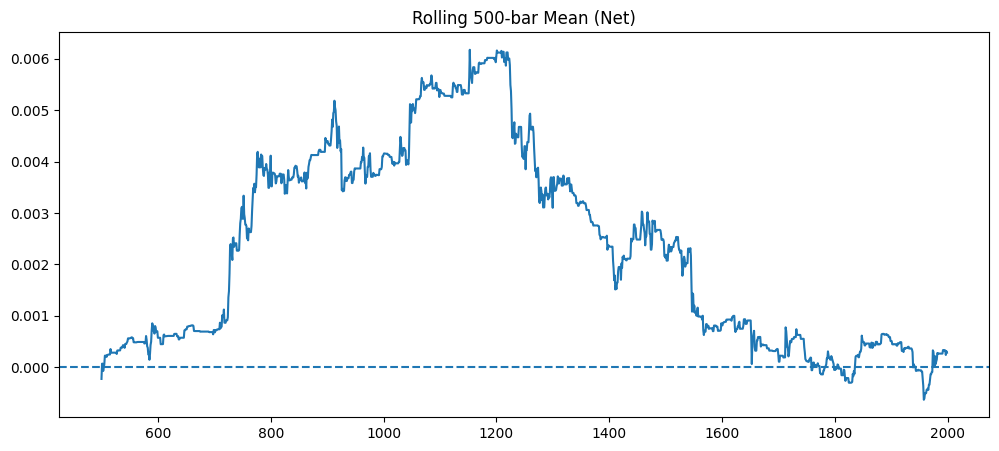

In [31]:

def apply_threshold_and_fees_perps(oos_trades: pl.DataFrame, tau: float, taker_fee: float, L: float) -> pl.DataFrame:
    out = (
        oos_trades
        .select(["datetime", "y_pred", "y_true"])
        .with_columns(
            pl.when(pl.col("y_pred").abs() > pl.lit(tau))
              .then(pl.col("y_pred").sign())
              .otherwise(pl.lit(0.0))
              .alias("position_thr")
        )
        .with_columns(
            (pl.lit(L) * pl.col("position_thr")).alias("w_thr")  # exposure in {-L,0,+L}
        )
        .with_columns(
            pl.col("w_thr").shift(1).fill_null(0.0).alias("w_prev")
        )
        .with_columns(
            (pl.col("w_thr") - pl.col("w_prev")).abs().alias("turnover_frac_thr")
        )
        .with_columns(
            (pl.lit(taker_fee) * pl.col("turnover_frac_thr")).clip(0.0, 0.99).alias("fee_frac_thr")
        )
        .with_columns(
            # per-bar log return (net): w_t * r_t + log(1 - fee_frac_t)
            (pl.col("w_thr") * pl.col("y_true") + (pl.lit(1.0) - pl.col("fee_frac_thr")).log()).alias("log_ret_net_thr")
        )
        .with_columns(
            pl.col("log_ret_net_thr").cum_sum().alias("equity_log_net_thr")
        )
        .drop(["w_prev"])
    )
    return out

# example run (use your best tau)
tau_test = float(best_tau)  # or your chosen value
tr2 = apply_threshold_and_fees_perps(oos_trades, tau_test, taker_fee=taker_fee, L=L)

print(
    tr2.select([
        (pl.col("position_thr") != 0).mean().alias("in_market_rate"),
        pl.col("turnover_frac_thr").mean().alias("mean_turnover"),
        pl.col("fee_frac_thr").mean().alias("mean_fee_frac"),
        pl.col("fee_frac_thr").sum().alias("total_fee_frac_sum"),
        pl.col("log_ret_net_thr").mean().alias("mean_logret_net"),
    ])
)

# quick view first rows
print(tr2.select(["datetime","position_thr","w_thr","turnover_frac_thr","fee_frac_thr","log_ret_net_thr"]).head(8))

# rolling stability (optional)
r_net = tr2["log_ret_net_thr"].to_numpy()
window = 500

rolling_mean = np.array([r_net[i-window:i].mean() if i >= window else np.nan for i in range(len(r_net))])
plt.figure(figsize=(12,5)); plt.plot(rolling_mean); plt.axhline(0, linestyle="--"); plt.title("Rolling 500-bar Mean (Net)"); plt.show()

## Thresholded Strategy Diagnostics (τ ≈ best value)

### 1️⃣ Trading Activity

- **In-market rate:** 30%  
  The strategy is exposed only 30% of the time.
  This confirms the threshold is highly selective.

- **Mean turnover:** 0.828  
  Average exposure change per bar is moderate.
  For reference:
  - 0 → no change
  - 2 → full enter/exit
  - 4 → full flip (+L to −L)

  So the strategy is not constantly flipping — it is relatively stable.

---

### 2️⃣ Fees

- **Mean fee fraction per bar:** 0.000373  
- **Total cumulative fee fraction (sum over bars):** 0.7452  

Because fees are proportional to:
$$
\text{fee\_frac}_t = \text{taker\_fee} \cdot |w_t - w_{t-1}|
$$

Lower turnover directly reduces fee drag.

The reduction in turnover (vs baseline ~1.75) explains part of the Sharpe improvement.

---

### 3️⃣ Mean Net Log Return

- **Mean net log-return per bar:** 0.00158  

This is substantially higher than the baseline (~0.00106).

This confirms:

> High-magnitude predictions carry higher expected returns.

---

### 4️⃣ Microstructure Sanity Check (First Rows)

From the table:

- Entering long (0 → +2 exposure): turnover = 2  
- Entering flat (±2 → 0): turnover = 2  
- Flipping long → short: turnover = 4  
- Staying in same position: turnover = 0  

Fees scale exactly as expected:
- turnover = 2 → fee_frac = 0.0009  
- turnover = 4 → fee_frac = 0.0018  

This matches:
$$
\text{fee\_frac}_t = 0.00045 \cdot |\Delta w_t|
$$

So the fee implementation is consistent with the perps-style turnover model.

---

## Rolling Stability (500-bar Mean)

The rolling 500-bar mean shows:

- Strong positive regime between ~700–1300
- Gradual decay afterward
- Recent regime near zero (but not deeply negative)

This confirms:

- The strategy is **regime dependent**
- Most of the performance came from a strong middle period
- Edge weakens in later regime

However, importantly:
- The rolling mean rarely becomes strongly negative
- The threshold dramatically stabilized drawdowns

---

## Overall Interpretation

The thresholded strategy:

- Trades less
- Pays fewer fees
- Concentrates on high-confidence predictions
- Improves risk-adjusted performance
- Reduces drawdown substantially

This strongly suggests that:

> The model's prediction magnitude contains economically meaningful ranking information.

The next robustness step would be:
- Validate the threshold on a strictly unseen sub-period.

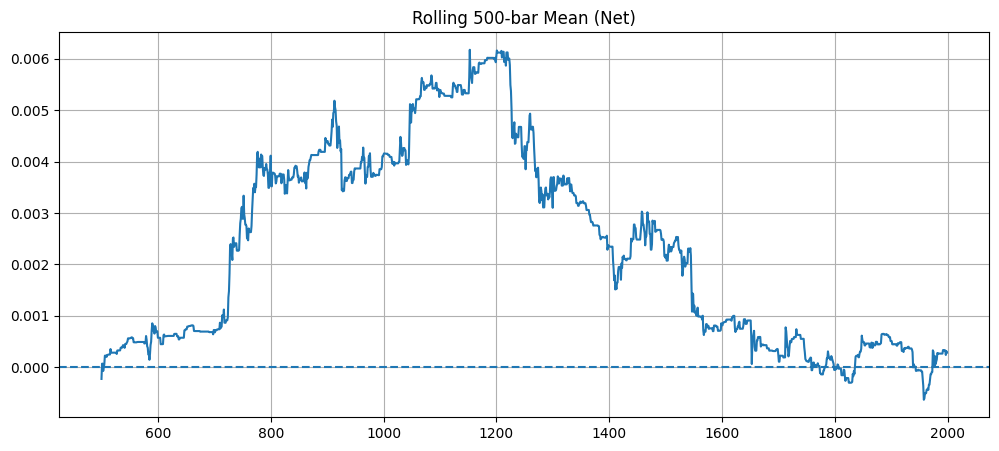

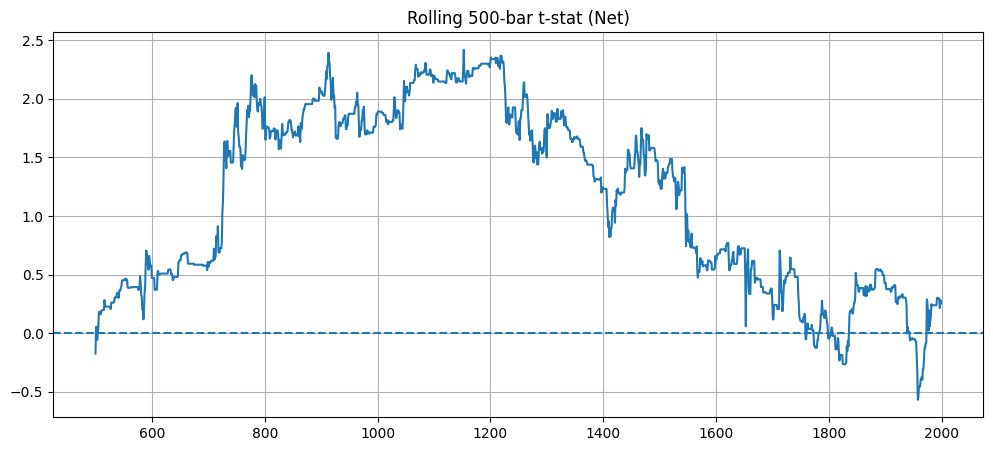

Recent 500-bar mean: 0.0002831795427482575
Recent 500-bar t-stat: 0.25360134680182195


In [32]:
# Rolling stability diagnostics on thresholded strategy (perps-style)

import numpy as np
import matplotlib.pyplot as plt

r_net = tr2["log_ret_net_thr"].to_numpy()

window = 500

rolling_mean = np.array([
    r_net[i-window:i].mean() if i >= window else np.nan
    for i in range(len(r_net))
])

rolling_t = np.array([
    compute_t(r_net[i-window:i]) if i >= window else np.nan
    for i in range(len(r_net))
])

plt.figure(figsize=(12,5))
plt.plot(rolling_mean)
plt.axhline(0, linestyle="--")
plt.title("Rolling 500-bar Mean (Net)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(rolling_t)
plt.axhline(0, linestyle="--")
plt.title("Rolling 500-bar t-stat (Net)")
plt.grid(True)
plt.show()

print("Recent 500-bar mean:", float(np.nanmean(r_net[-500:])))
print("Recent 500-bar t-stat:", float(compute_t(r_net[-500:])))



Confidence filter + regime filter (rolling t-stat)

This section adds a two-layer trading filter on top of the stitched OOS predictions:
	1.	Confidence / no-trade zone (threshold $\tau$)
We only trade when the model’s prediction magnitude is “large enough”:
$$
\text{pos}^{(\tau)}t =
\begin{cases}
\mathrm{sign}(\hat y_t) & \text{if } |\hat y_t| > \tau \
0 & \text{otherwise}
\end{cases}
$$
and the gross per-bar log return is:
$$
r^{(\tau)}{t,\text{gross}} = \text{pos}^{(\tau)}_t \cdot y_t
$$
	2.	Regime filter using a rolling t-stat of past realized strategy returns
We compute a rolling t-stat on the net returns of the $\tau$-filtered strategy over the last t_window bars:
$$
t_t = \frac{\bar r}{s_r/\sqrt{n}}
$$
Then we shift it by 1 bar so that the decision at time $t$ only uses information up to $t-1$ (no lookahead).

We only allow positions when the shifted rolling t-stat is above a minimum threshold t_min:
$$
\text{position}t =
\begin{cases}
\text{pos}^{(\tau)}t & \text{if } t{t-1} \ge t{\min} \
0 & \text{otherwise}
\end{cases}
$$
	3.	Fees + equity recomputed on the final filtered position stream
After the regime filter changes the position stream, we recompute fees and net returns again, and build the final log-equity:
$$
\log E_t = \sum_{i \le t} r_{i,\text{net}}
$$

In [33]:
# ----------------------------
# Utilities (single source of truth)
# ----------------------------
def tstat_np(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    if x.size < 2:
        return np.nan
    s = x.std(ddof=1)
    if s == 0 or np.isnan(s):
        return np.nan
    return x.mean() / (s / np.sqrt(x.size))

def max_dd_log(eq_log: np.ndarray) -> float:
    peak = np.maximum.accumulate(eq_log)
    return float((eq_log - peak).min())

def summarize_from_logret(log_ret: np.ndarray, annualized_rate: float) -> dict:
    mean = float(np.mean(log_ret))
    std  = float(np.std(log_ret, ddof=1)) if len(log_ret) > 1 else np.nan
    t    = float(tstat_np(log_ret))
    sharpe = float((mean / std) * np.sqrt(annualized_rate)) if std and not np.isnan(std) else np.nan
    eq_log = np.cumsum(log_ret)
    return {
        "mean_net": mean,
        "t_net": t,
        "sharpe_net": sharpe,
        "final_eq_net": float(np.exp(eq_log[-1])) if len(eq_log) else np.nan,
        "max_dd_log_net": max_dd_log(eq_log) if len(eq_log) else np.nan,
    }

### Utilities

This section defines small reusable helper functions used throughout the notebook:

- **tstat_np(x)**  
  Computes the classical t-statistic of a return series:
  $
  t = \frac{\bar r}{s_r / \sqrt{n}}
  $
  where $\bar r$ is the sample mean and $s_r$ the sample standard deviation.

- **max_dd_log(eq\_log)**  
  Computes maximum drawdown in log-equity space:
  $
  \text{DD}_t = \log E_t - \max_{s \le t} \log E_s
  $
  and returns the minimum value.

- **summarize\_from\_logret(log\_ret, annualized\_rate)**  
  Builds a compact performance summary from per-bar log returns:
  - Mean return
  - t-statistic
  - Annualized Sharpe:
    $
    \text{Sharpe} = \frac{\bar r}{s_r} \sqrt{\text{annualized\_rate}}
    $
  - Final equity:
    $
    E_T = \exp\left(\sum_{t=1}^{T} r_t\right)
    $
  - Maximum drawdown (log space)

These functions centralize performance calculations to avoid duplication and ensure consistency across experiments.

In [34]:
# ----------------------------
# Strategy: tau filter + rolling t-stat regime filter (perps-style fees)
# ----------------------------
def apply_tau_and_tfilter_perps(
    oos_trades: pl.DataFrame,
    tau: float,
    t_window: int,
    t_min: float,
    taker_fee: float,
    L: float,
) -> pl.DataFrame:
    # 1) Tau filter -> position in {-1,0,+1}
    tr = (
        oos_trades
        .select(["datetime", "y_pred", "y_true"])
        .with_columns(
            pl.when(pl.col("y_pred").abs() > pl.lit(tau))
              .then(pl.col("y_pred").sign())
              .otherwise(pl.lit(0.0))
              .alias("pos_tau")
        )
    )

    # 2) Compute perps-style net returns for pos_tau (for rolling t-stat)
    # exposure w_tau in {-L,0,+L}
    tr = (
        tr
        .with_columns((pl.lit(L) * pl.col("pos_tau")).alias("w_tau"))
        .with_columns(pl.col("w_tau").shift(1).fill_null(0.0).alias("w_tau_prev"))
        .with_columns((pl.col("w_tau") - pl.col("w_tau_prev")).abs().alias("turnover_tau"))
        .with_columns((pl.lit(taker_fee) * pl.col("turnover_tau")).clip(0.0, 0.99).alias("fee_frac_tau"))
        .with_columns(
            (pl.col("w_tau") * pl.col("y_true") + (pl.lit(1.0) - pl.col("fee_frac_tau")).log()).alias("r_net_tau")
        )
        .drop(["w_tau_prev"])
    )

    # 3) Rolling t-stat on past net returns (NO lookahead)
    r_net_tau = tr["r_net_tau"].to_numpy()
    roll_t = np.full(len(r_net_tau), np.nan, dtype=float)
    for i in range(t_window - 1, len(r_net_tau)):
        roll_t[i] = tstat_np(r_net_tau[i - t_window + 1 : i + 1])

    # shift by 1 so decision at time t uses info up to t-1
    roll_t = np.roll(roll_t, 1)
    roll_t[0] = np.nan
    tr = tr.with_columns(pl.Series("roll_t", roll_t))

    # 4) Regime filter: if roll_t < t_min => flat
    tr = tr.with_columns(
        pl.when(pl.col("roll_t").is_not_null() & (pl.col("roll_t") >= pl.lit(t_min)))
          .then(pl.col("pos_tau"))
          .otherwise(pl.lit(0.0))
          .alias("position")
    )

    # 5) Recompute FINAL perps-style fees + net returns on filtered position
    tr = (
        tr
        .with_columns((pl.lit(L) * pl.col("position")).alias("w"))
        .with_columns(pl.col("w").shift(1).fill_null(0.0).alias("w_prev"))
        .with_columns((pl.col("w") - pl.col("w_prev")).abs().alias("turnover"))
        .with_columns((pl.lit(taker_fee) * pl.col("turnover")).clip(0.0, 0.99).alias("fee_frac"))
        .with_columns(
            (pl.col("w") * pl.col("y_true") + (pl.lit(1.0) - pl.col("fee_frac")).log()).alias("log_ret_net")
        )
        .with_columns(pl.col("log_ret_net").cum_sum().alias("eq_log_net"))
        .drop(["w_prev"])
    )

    return tr

## Tau Filter + Rolling t-Statistic Regime Filter (Perps-Style)

This section implements a two-layer trading filter on the stitched out-of-sample predictions.

---

### 1️⃣ Confidence Filter (No-Trade Zone)

We first apply a magnitude threshold $\tau$ to the model predictions:

$
\text{pos}^{(\tau)}_t =
\begin{cases}
\operatorname{sign}(\hat y_t) & \text{if } |\hat y_t| > \tau \\
0 & \text{otherwise}
\end{cases}
$

This removes low-conviction signals and keeps only stronger predictions.

---

### 2️⃣ Perpetual Futures Fee Model (Turnover-Based)

We trade with leverage $L$, so exposure is:

$
w_t = L \cdot \text{pos}_t
$

Turnover is defined as the change in exposure:

$
\text{turnover}_t = |w_t - w_{t-1}|
$

Transaction cost (fraction of equity):

$
\text{fee\_frac}_t = \text{taker\_fee} \cdot \text{turnover}_t
$

Per-bar net log return:

$
r_{t,\text{net}} = w_t \cdot y_t + \log(1 - \text{fee\_frac}_t)
$

This properly scales fees with leverage and correctly charges flips ($+L \rightarrow -L$) and entries/exits.

---

### 3️⃣ Rolling t-Statistic Regime Filter

We compute a rolling t-statistic of recent realized net returns over a window of size $W$:

$
t_t =
\frac{\bar r_{t-W+1:t}}{s_{t-W+1:t} / \sqrt{W}}
$

To avoid lookahead bias, we shift this by one bar so the decision at time $t$ uses information up to $t-1$.

We then allow trading only when recent realized performance is strong enough:

$
\text{position}_t =
\begin{cases}
\text{pos}^{(\tau)}_t & \text{if } t_{t-1} \ge t_{\min} \\
0 & \text{otherwise}
\end{cases}
$

This acts as a regime filter:  
we trade only when the strategy itself has demonstrated recent statistical strength.

---

### 4️⃣ Final Equity Construction

After applying both filters, we recompute turnover, fees, and net returns on the final position stream:

$
\log E_t = \sum_{i=1}^{t} r_{i,\text{net}}
$

$
E_t = \exp(\log E_t)
$

---

### Interpretation

This framework combines:

- **Signal confidence filtering** (via $\tau$)
- **Adaptive regime gating** (via rolling t-stat)
- **Realistic perps-style transaction costs**
- **Strict no-lookahead implementation**

The goal is not only to increase average return, but to reduce exposure during periods when the strategy’s realized edge weakens.

In [35]:
# ----------------------------
# Example run (choose tau, window, t_min)
# ----------------------------
abs_pred = oos_trades["y_pred"].abs().to_numpy()
tau20 = float(np.quantile(abs_pred, 0.20))

t_window = 500
t_min = 0.5

tr_f = apply_tau_and_tfilter_perps(
    oos_trades,
    tau=tau20,
    t_window=t_window,
    t_min=t_min,
    taker_fee=taker_fee,
    L=L,
)

log_ret = tr_f["log_ret_net"].to_numpy()
summary = summarize_from_logret(log_ret, annualized_rate)

extra = tr_f.select([
    (pl.col("position") != 0).mean().alias("in_market_rate"),
    pl.col("turnover").mean().alias("mean_turnover"),
    pl.col("fee_frac").sum().alias("total_fee_frac_sum"),
]).to_dicts()[0]

print("tau:", tau20, "t_window:", t_window, "t_min:", t_min)
print({**summary, **extra})

tau: 0.005333085544407368 t_window: 500 t_min: 0.5
{'mean_net': 0.0015231750439852476, 't_net': 1.4859927312054864, 'sharpe_net': 0.19114161580602004, 'final_eq_net': 21.03862953186035, 'max_dd_log_net': -1.1678732633590698, 'in_market_rate': 0.686, 'mean_turnover': 1.4559999704360962, 'total_fee_frac_sum': 1.3104000091552734}


### Tau + Rolling t-Stat Filter — Results Interpretation

With  
- $\tau = 0.00533$  
- $t\_\text{window} = 500$  
- $t_{\min} = 0.5$  

the stitched out-of-sample results are:

- Mean net return per bar: $0.00152$
- t-stat: $1.49$
- Annualized Sharpe: $0.19$
- Final equity multiple: $\approx 21.0\times$
- Max drawdown (log): $-1.17$
- In-market rate: $68.6\%$

---

#### Interpretation

The combined confidence filter ($\tau$) and regime filter (rolling t-stat) preserves strong compounding while slightly reducing exposure during weak periods.  

However:

- The statistical strength remains moderate ($t \approx 1.5$).
- Drawdowns are still large (log DD of $-1.17$ corresponds to a substantial capital drawdown).
- Turnover remains elevated, implying meaningful fee impact.

Overall, the filter improves risk-adjusted behavior relative to the unfiltered strategy, but the edge remains regime-dependent and statistically fragile rather than decisively robust.

## Half-Sample Parameter Validation (Tau + Regime Filter)

Up to this point, parameters such as $\tau$ (prediction threshold) and $t_{\min}$ (minimum rolling t-stat) were chosen using the full stitched out-of-sample dataset.  

However, selecting hyperparameters on the same data used for evaluation introduces adaptive bias.

To reduce this risk, we now apply a **time-based validation split**:

1. **Early Half (Selection Phase)**  
   - Split the stitched OOS data into two equal chronological halves.
   - Run a small grid over $(\tau, t_{\min})$.
   - Select the parameter combination that maximizes statistical strength (e.g., highest $t$-stat).

2. **Late Half (Validation Phase)**  
   - Freeze the selected parameters.
   - Evaluate performance on the second half of the data.
   - Compute:
     - Mean net return
     - $t$-statistic
     - Sharpe ratio
     - Final equity
     - Drawdown
     - In-market rate

This procedure ensures that parameter selection is separated from performance evaluation in time, reducing the likelihood that improvements are driven purely by adaptive overfitting.

In [36]:

# ---------------------------------
# 1) Split stitched OOS in half
# ---------------------------------
N = oos_trades.height
mid = N // 2

oos_early = oos_trades.slice(0, mid)
oos_late  = oos_trades.slice(mid, N - mid)

# ---------------------------------
# 2) Parameter grid (reasonable range)
# ---------------------------------
abs_pred = oos_trades["y_pred"].abs().to_numpy()

taus = [float(np.quantile(abs_pred, q)) for q in [0.10, 0.20, 0.30, 0.40]]
t_mins = [0.0, 0.25, 0.5, 0.75]
t_window = 500

rows = []

# ---------------------------------
# 3) Grid search on EARLY half only
# ---------------------------------
for tau in taus:
    for t_min in t_mins:
        tr_early = apply_tau_and_tfilter_perps(
            oos_early,
            tau=tau,
            t_window=t_window,
            t_min=t_min,
            taker_fee=taker_fee,
            L=L,
        )

        log_ret_early = tr_early["log_ret_net"].to_numpy()
        s_early = summarize_from_logret(log_ret_early, annualized_rate)

        rows.append({
            "tau": tau,
            "t_min": t_min,
            "mean_early": s_early["mean_net"],
            "t_early": s_early["t_net"],
            "sharpe_early": s_early["sharpe_net"],
        })

res_early = pl.DataFrame(rows).sort("t_early", descending=True)

print("=== EARLY HALF (selection) ===")
print(res_early)

# ---------------------------------
# 4) Select best params from early
# ---------------------------------
best_tau = float(res_early[0, "tau"])
best_tmin = float(res_early[0, "t_min"])

print("\nSelected parameters from EARLY half:")
print("tau:", best_tau, "t_min:", best_tmin)

# ---------------------------------
# 5) Evaluate on LATE half (true validation)
# ---------------------------------
tr_late = apply_tau_and_tfilter_perps(
    oos_late,
    tau=best_tau,
    t_window=t_window,
    t_min=best_tmin,
    taker_fee=taker_fee,
    L=L,
)

log_ret_late = tr_late["log_ret_net"].to_numpy()
s_late = summarize_from_logret(log_ret_late, annualized_rate)

print("\n=== LATE HALF (validation) ===")
print(s_late)

print("In-market rate (late):",
      float((tr_late["position"] != 0).mean()))

=== EARLY HALF (selection) ===
shape: (16, 5)
┌──────────┬───────┬────────────┬──────────┬──────────────┐
│ tau      ┆ t_min ┆ mean_early ┆ t_early  ┆ sharpe_early │
│ ---      ┆ ---   ┆ ---        ┆ ---      ┆ ---          │
│ f64      ┆ f64   ┆ f64        ┆ f64      ┆ f64          │
╞══════════╪═══════╪════════════╪══════════╪══════════════╡
│ 0.01208  ┆ 0.0   ┆ 0.001776   ┆ 1.173457 ┆ 0.213462     │
│ 0.01208  ┆ 0.25  ┆ 0.001776   ┆ 1.173457 ┆ 0.213462     │
│ 0.01208  ┆ 0.75  ┆ 0.001736   ┆ 1.148637 ┆ 0.208947     │
│ 0.01208  ┆ 0.5   ┆ 0.001738   ┆ 1.148628 ┆ 0.208945     │
│ 0.008488 ┆ 0.0   ┆ 0.001768   ┆ 1.119277 ┆ 0.203606     │
│ …        ┆ …     ┆ …          ┆ …        ┆ …            │
│ 0.005333 ┆ 0.5   ┆ 0.001525   ┆ 0.937498 ┆ 0.170539     │
│ 0.002546 ┆ 0.0   ┆ 0.001558   ┆ 0.933971 ┆ 0.169897     │
│ 0.002546 ┆ 0.75  ┆ 0.001443   ┆ 0.882557 ┆ 0.160545     │
│ 0.002546 ┆ 0.25  ┆ 0.001443   ┆ 0.868801 ┆ 0.158042     │
│ 0.002546 ┆ 0.5   ┆ 0.001325   ┆ 0.804581 ┆ 0.14636  

### Late-Half Validation Results (Out-of-Sample)

Using parameters selected on the **early half**, we evaluate performance on the **late half** (unseen during selection).

**Late-half metrics:**

- Mean net return per bar: $0.00061$
- $t$-statistic: $0.52$
- Annualized Sharpe: $0.09$
- Final equity multiple: $\approx 1.84\times$
- Max drawdown (log): $-0.80$
- In-market rate: $46.6\%$

---

### Interpretation

Performance in the validation period is **substantially weaker** than in the early half:

- The $t$-stat drops from meaningful levels to $\approx 0.5$, which is statistically indistinguishable from noise.
- Sharpe ratio declines materially.
- Equity growth remains positive, but much more modest.
- Drawdowns remain significant relative to the achieved return.

This suggests that a large portion of the performance observed during parameter selection was **regime-dependent** and does not fully persist out-of-sample.

In short:

- The combined $\tau$ + rolling $t$-stat filter improves early-period results.
- However, its statistical edge weakens considerably in the validation half.
- The strategy exhibits instability across regimes rather than uniform robustness.

Further robustness testing (e.g., rolling re-estimation, alternative time splits, or cross-asset validation) would be required before considering this configuration reliable.

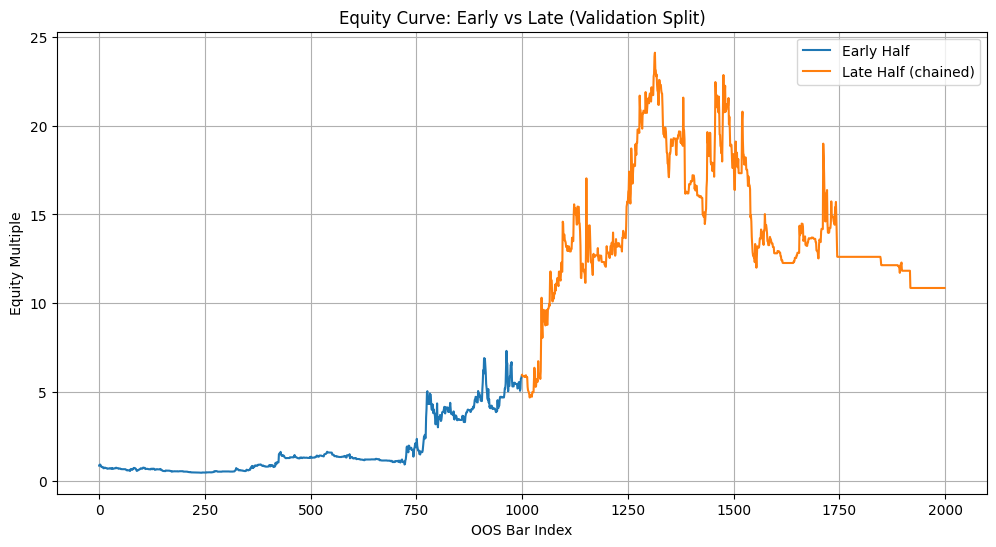

In [37]:
# Build equity for early
tr_early_best = apply_tau_and_tfilter_perps(
    oos_early,
    tau=best_tau,
    t_window=t_window,
    t_min=best_tmin,
    taker_fee=taker_fee,
    L=L,
)

eq_early = np.exp(tr_early_best["eq_log_net"].to_numpy())

# Late equity
eq_late = np.exp(tr_late["eq_log_net"].to_numpy())

plt.figure(figsize=(12,6))
plt.plot(eq_early, label="Early Half")
plt.plot(range(len(eq_early), len(eq_early)+len(eq_late)),
         eq_late * eq_early[-1],
         label="Late Half (chained)")
plt.title("Equity Curve: Early vs Late (Validation Split)")
plt.ylabel("Equity Multiple")
plt.xlabel("OOS Bar Index")
plt.grid(True)
plt.legend()
plt.show()

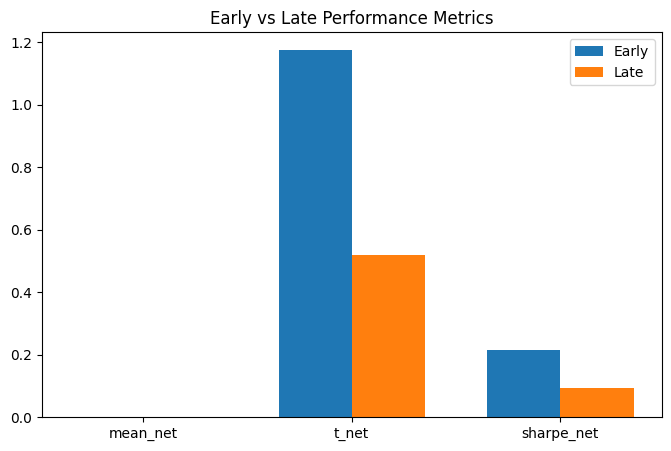

In [38]:
metrics = ["mean_net", "t_net", "sharpe_net"]

early_vals = [res_early[0, "mean_early"],
              res_early[0, "t_early"],
              res_early[0, "sharpe_early"]]

late_vals = [s_late["mean_net"],
             s_late["t_net"],
             s_late["sharpe_net"]]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, early_vals, width, label="Early")
plt.bar(x + width/2, late_vals, width, label="Late")

plt.xticks(x, metrics)
plt.title("Early vs Late Performance Metrics")
plt.legend()
plt.show()

## Early vs Late Split — Robustness Assessment

To evaluate parameter stability, we split the stitched out-of-sample data into two equal chronological halves:

- **Early half**: used for parameter selection  
- **Late half**: used for validation (unseen during selection)

---

### Key Observations

**1️⃣ Statistical Strength Weakens**

- Early half: $t \approx 1.17$, Sharpe $\approx 0.21$
- Late half: $t \approx 0.52$, Sharpe $\approx 0.09$

The statistical edge declines materially in the validation period.  
While returns remain positive, they are no longer statistically distinguishable from noise.

---

**2️⃣ Equity Dynamics Are Regime-Dependent**

- The early half shows persistent compounding and strong slope.
- The late half begins with continuation but then flattens and weakens.
- Performance concentration is clearly not uniform over time.

---

**3️⃣ Drawdowns Remain Large**

Even in validation:

- Maximum log drawdown remains substantial.
- Risk-adjusted performance does not improve proportionally to returns.

---

### Interpretation

The combined $\tau$ (confidence filter) and rolling $t$-stat (regime filter) strategy:

- Demonstrates meaningful performance in one regime.
- Fails to maintain similar statistical strength in later unseen data.
- Exhibits regime dependence rather than stable cross-period robustness.

This suggests the model may be capturing a structural market condition that was present in the early half but weakened in the later half.

The next step is to explicitly test **regime-conditioned performance**, rather than further tuning hyperparameters.